# Code 8: Approximate Bayesian Computation

```{admonition} This is a reference notebook for the book Bayesian Modeling and Computation in Python
:class: tip, dropdown
The textbook is not needed to use or run this code, though the context and explanation is missing from this notebook.

If you'd like a copy it's available
[from the CRC Press](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368)
or from [Amazon](https://www.routledge.com/Bayesian-Modeling-and-Computation-in-Python/Martin-Kumar-Lao/p/book/9780367894368).
``

In [1]:
%matplotlib inline
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
from scipy import stats

from scr.rf_selector import select_model

In [2]:
az.style.use("arviz-grayscale")
plt.rcParams['figure.dpi'] = 300
np.random.seed(1346)

## 8.3 Approximating the Approximated Posterior

### Figure 8.2

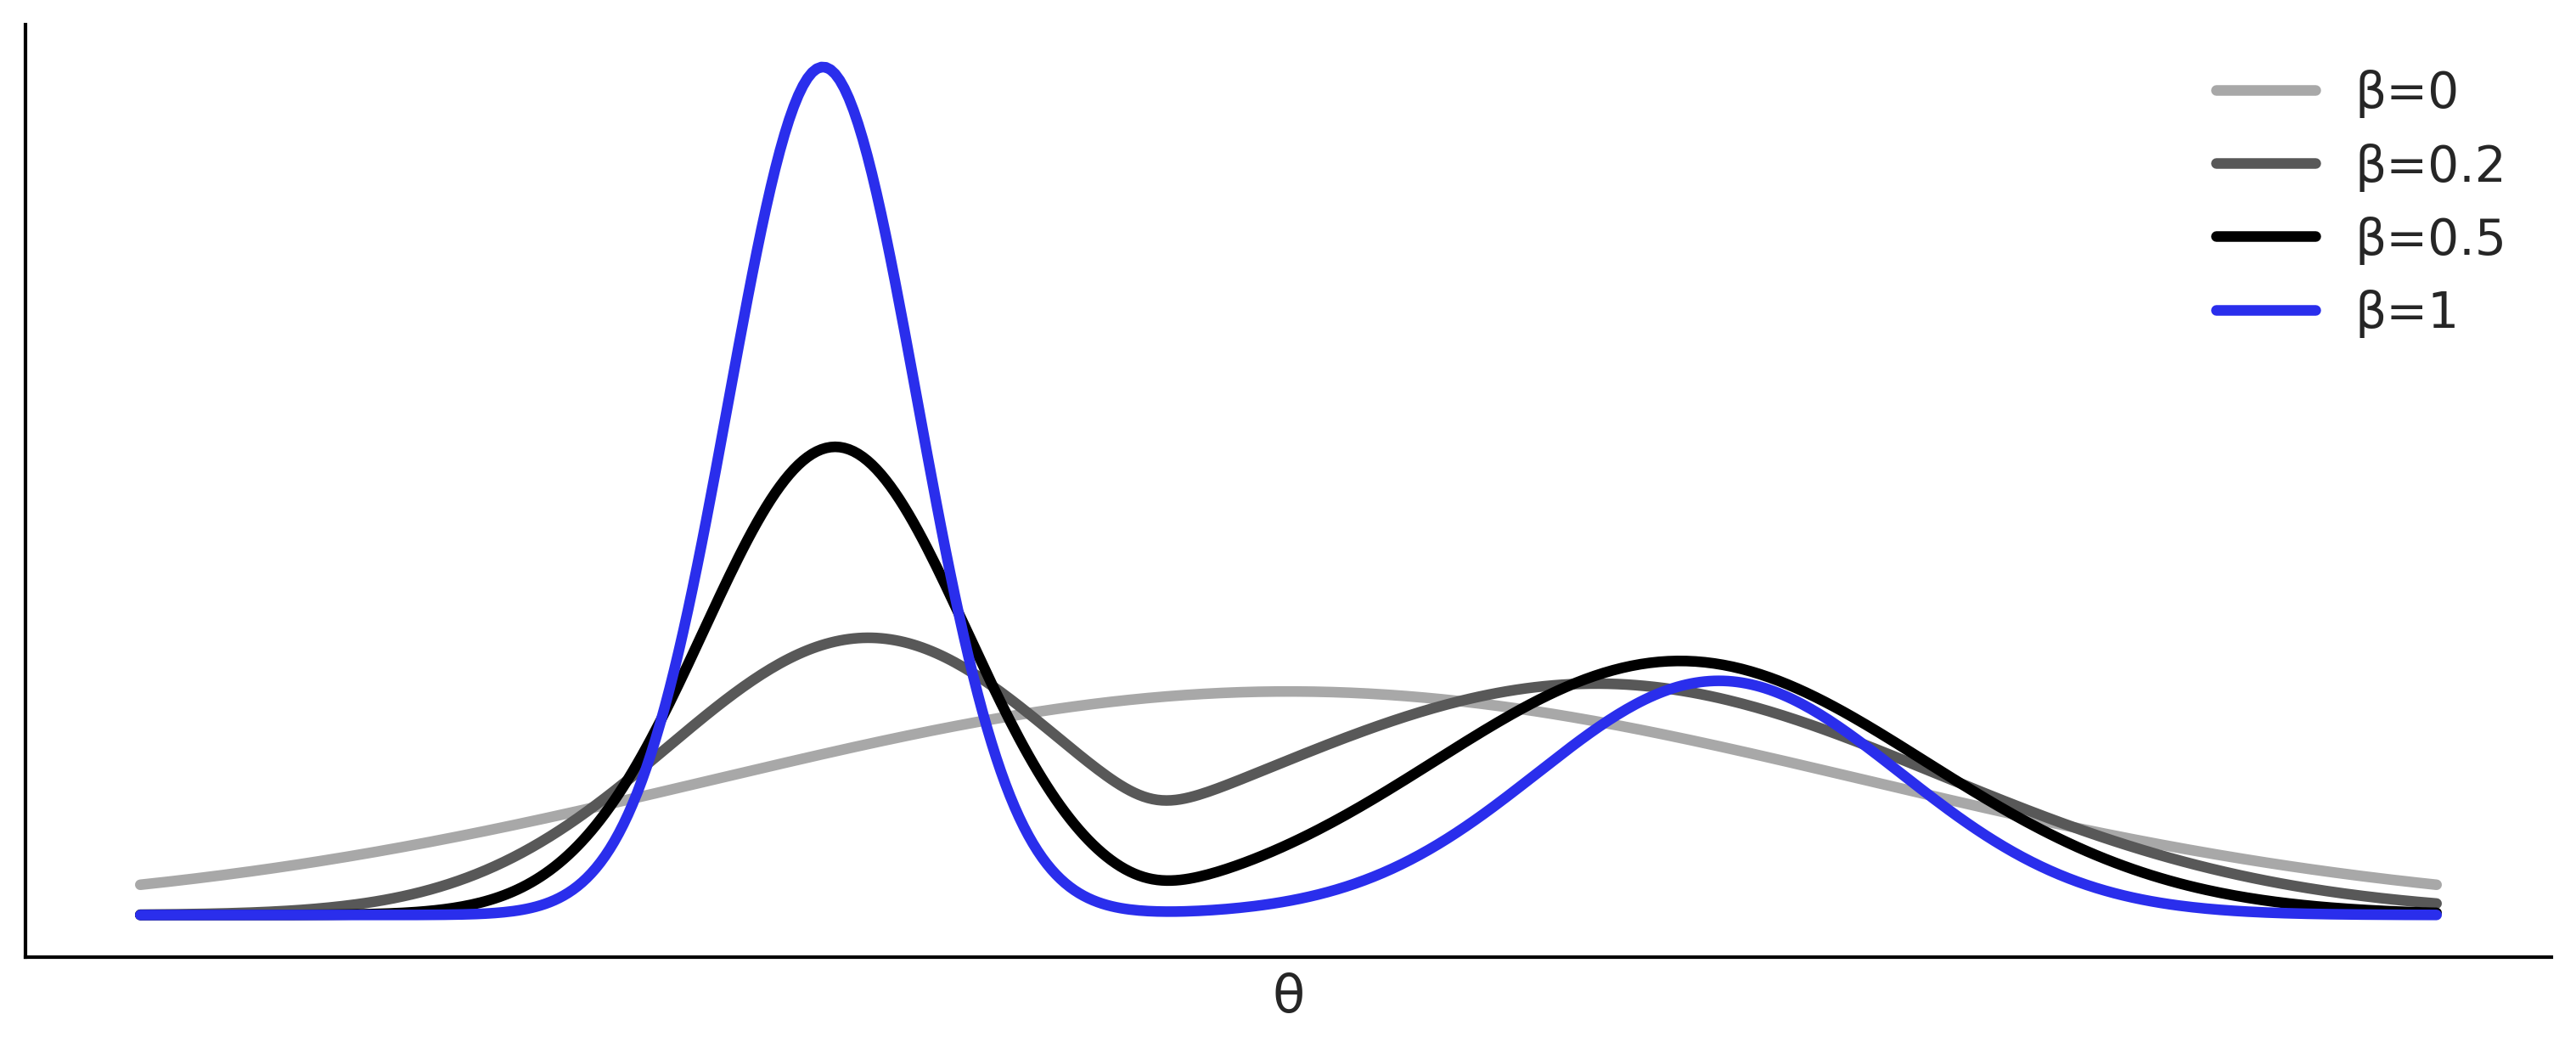

In [3]:
a = stats.norm(-2.5, 0.5)
b = stats.norm(2.5, 1)
c = stats.norm(0, 3)
x = np.linspace(-6, 6, 500)

lpdf = 0.65 * a.pdf(x) + 0.35* b.pdf(x)
ppdf = c.pdf(x)
_, ax = plt.subplots(figsize=(10, 4))
for c, β in zip(["#A8A8A8", "#585858", "#000000", "#2a2eec"],
                [0, 0.2, 0.5, 1]):
    post = ppdf * lpdf**β
    post /= post.sum()
    ax.plot(x, post, lw=3, label=f"β={β}", color=c)
ax.set_yticks([])
ax.set_xticks([])
ax.set_xlabel("θ")
ax.legend()
# plt.savefig("img/chp08/smc_tempering.png")
plt.show();

## 8.3 Fitting a Gaussian the ABC-way
### Likelihood Model

In [4]:
data = np.random.normal(loc=0, scale=1, size=1000)

In [5]:
with pm.Model() as gauss0:
    μ = pm.Normal("μ", mu=0, sigma=1)
    σ = pm.HalfNormal("σ", sigma=1)
    s = pm.Normal("s", μ, σ, observed=data)
    trace_g0 = pm.sample(return_inferencedata=False)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [σ, μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
The acceptance probability does not match the target. It is 0.8843681703725781, but should be close to 0.8. Try to increase the number of tuning steps.


In [6]:
with gauss0:
    summ0 = az.summary(trace_g0)
summ0

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ -0.062  0.032  -0.116   -0.001      0.001      0.0    3584.0    2655.0   
σ  1.000  0.022   0.957    1.040      0.000      0.0    3602.0    2916.0   

   r_hat  
μ    1.0  
σ    1.0

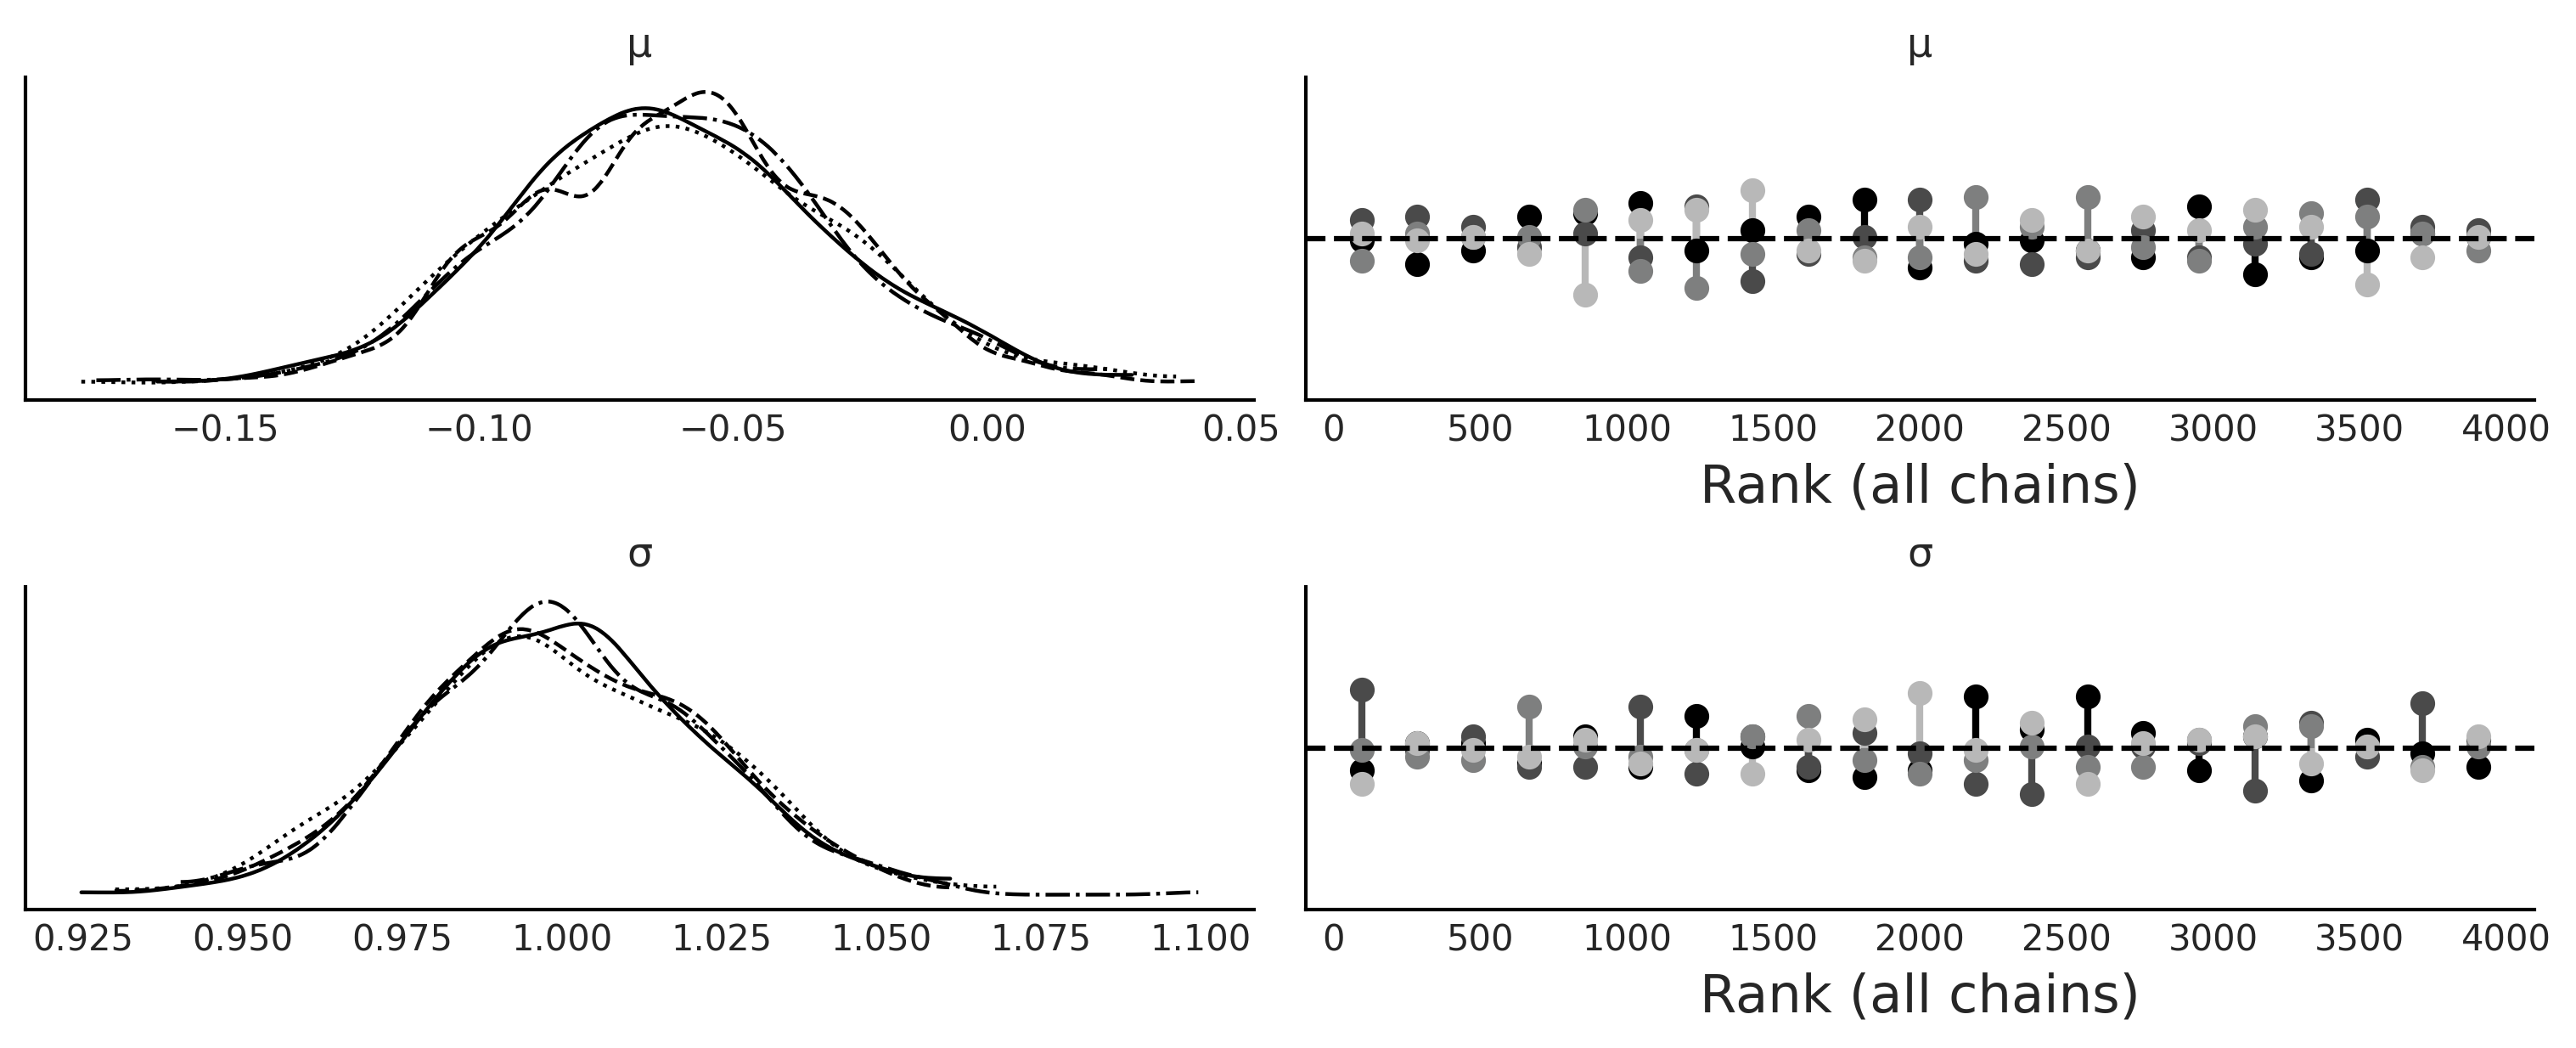

In [7]:
with gauss0:
    az.plot_trace(trace_g0, kind="rank_vlines", figsize=(10, 4));

### SMC-ABC - Sequential Monte Carlo Approximate Bayesian Computation

In [8]:
def normal_simulator(μ, σ):
    return np.random.normal(μ, σ, 1000)

### Code 8.2 and Figure 8.3

In [9]:
with pm.Model() as gauss:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    # pm.Simulator distribution accepts function and parameter list
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     distance="gaussian", # weighted euclidean distance
                     sum_stat="sort", # sort the data prior to calculating the distance       
                     epsilon=1, # scale of the distamce function
                     observed=data)
    # pm.sample_smc
    trace_g = pm.sample_smc(kernel="ABC",
                            parallel=True)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.004
Stage:   1 Beta: 0.014
Stage:   2 Beta: 0.049
Stage:   3 Beta: 0.174
Stage:   4 Beta: 0.576
Stage:   5 Beta: 1.000


In [10]:
with gauss:
    summ = az.summary(trace_g)
summ

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
μ -0.062  0.044  -0.148    0.017        0.0      0.0   12163.0   11568.0   
σ  0.997  0.039   0.924    1.070        0.0      0.0   11727.0   11157.0   

   r_hat  
μ    1.0  
σ    1.0

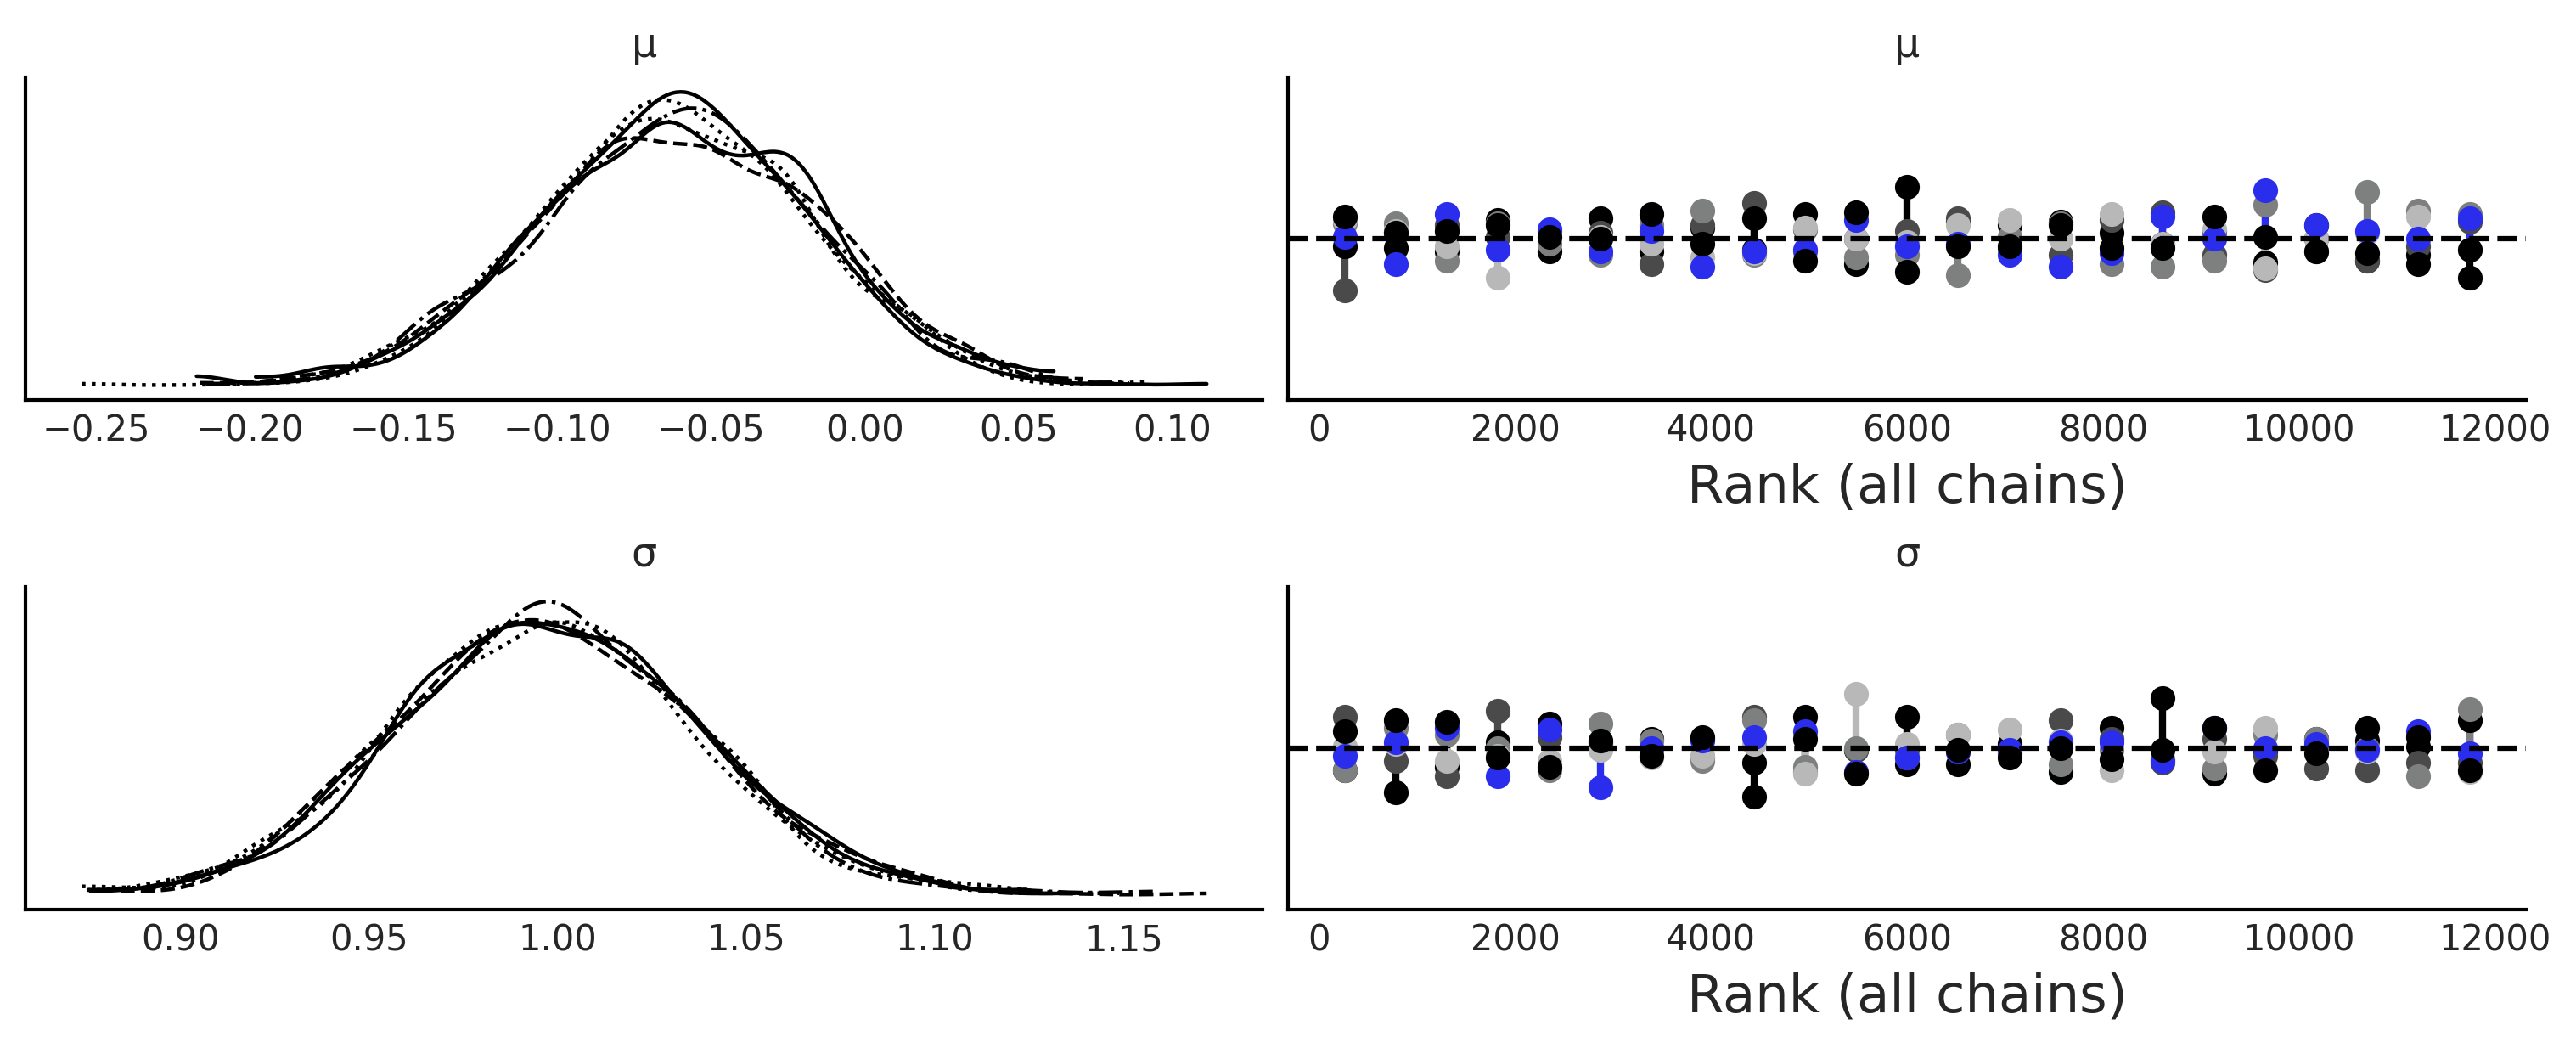

In [11]:
with gauss:
    az.plot_trace(trace_g, kind="rank_vlines", figsize=(10, 4));
# plt.savefig('img/chp08/trace_g.png')

## 8.4 Choosing the Distance Function, $\epsilon$ and the Summary Statistics

### Codes 8.4, 8.5, 8.6, 8.7, and 8.8
#### 8.4.2 Choosing $\epsilon$

In [12]:
with pm.Model() as gauss_001:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=0.1,
                     observed=data)
    trace_g_001, sim_data_001 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)

with pm.Model() as gauss_01:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=1,
                     observed=data)
    trace_g_01, sim_data_01 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)
    
with pm.Model() as gauss_02:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=2,
                     observed=data)
    trace_g_02, sim_data_02 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)  
    
with pm.Model() as gauss_05:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=5,
                     observed=data)
    trace_g_05, sim_data_05 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)
    
with pm.Model() as gauss_10:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Simulator('s', normal_simulator, params=[μ, σ],
                     sum_stat="sort",
                     epsilon=10,
                     observed=data)
    trace_g_10, sim_data_10 = pm.sample_smc(kernel="ABC",
                                      parallel=True,
                                      save_sim_data=True)

with pm.Model() as gauss_NUTS:
    μ = pm.Normal('μ', mu=0, sd=1)
    σ = pm.HalfNormal('σ', sd=1)
    s = pm.Normal('s', μ, σ,
                  observed=data)
    trace_g_nuts = pm.sample(return_inferencedata=False)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.000
Stage:   1 Beta: 0.000
Stage:   2 Beta: 0.000
Stage:   3 Beta: 0.002
Stage:   4 Beta: 0.005
Stage:   5 Beta: 0.016
Stage:   6 Beta: 0.034
Stage:   7 Beta: 0.064
Stage:   8 Beta: 0.113
Stage:   9 Beta: 0.205
Stage:  10 Beta: 0.328
Stage:  11 Beta: 0.461
Stage:  12 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.003
Stage:   1 Beta: 0.014
Stage:   2 Beta: 0.048
Stage:   3 Beta: 0.166
Stage:   4 Beta: 0.549
Stage:   5 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.015
Stage:   1 Beta: 0.059
Stage:   2 Beta: 0.203
Stage:   3 Beta: 0.681
Stage:   4 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.092
Stage:   1 Beta: 0.367
Stage:   2 Beta: 1.000
Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.366
Stage:   1 Beta: 1.000
Auto-assigning NUTS sampler...
Initializing NUTS usin

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [13]:
idata = az.from_pymc3(trace=trace_g_10)
idata

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data

In [14]:
sim_idata = az.from_dict(sim_data_10)
sim_idata

Inference data with groups:
	> posterior

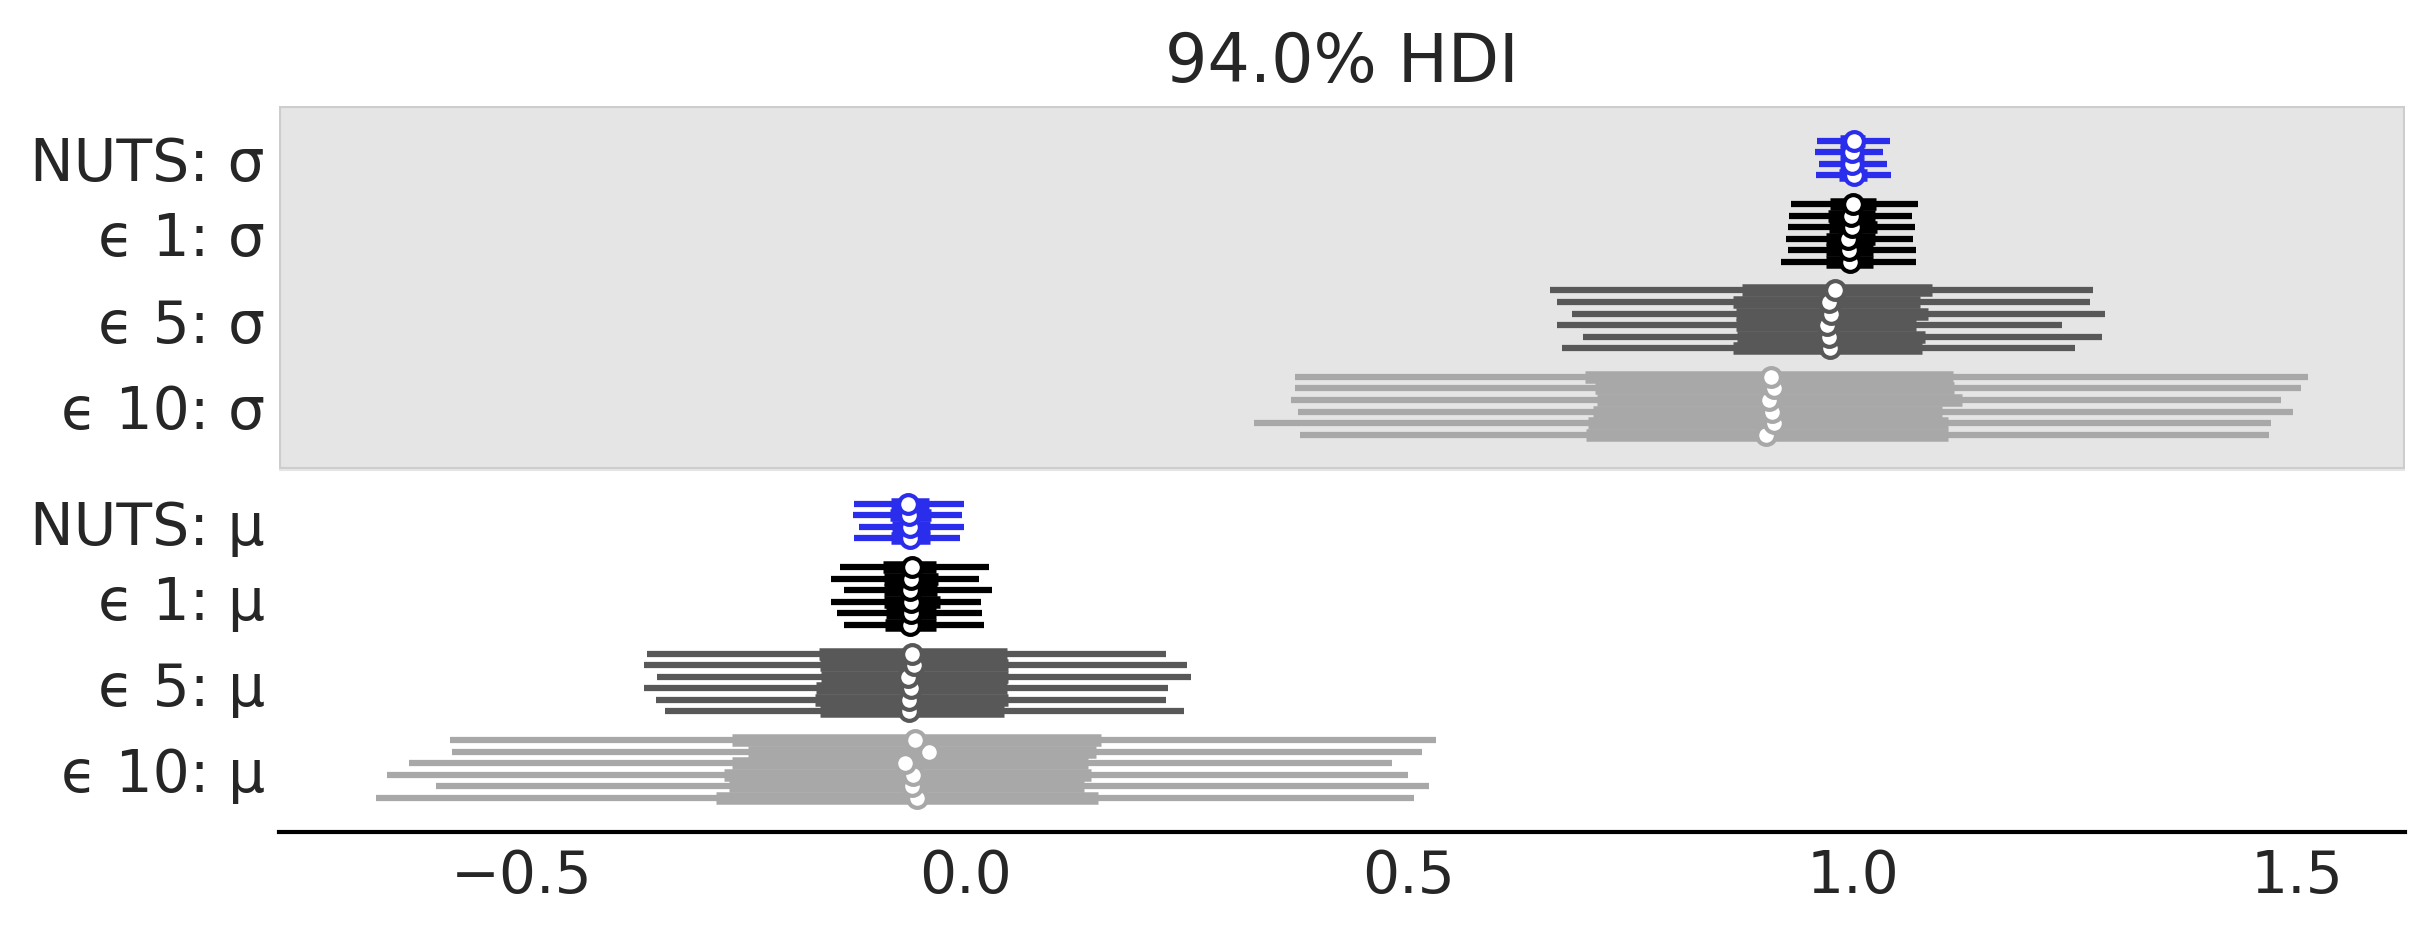

In [15]:
traces = [trace_g_nuts, trace_g_01, trace_g_05, trace_g_10]
az.plot_forest(traces, model_names=["NUTS", "ϵ 1", "ϵ 5", "ϵ 10"],
               colors=["#2a2eec", "#000000", "#585858", "#A8A8A8"],
               figsize=(8, 3));
# plt.savefig("img/chp08/trace_g_many_eps.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


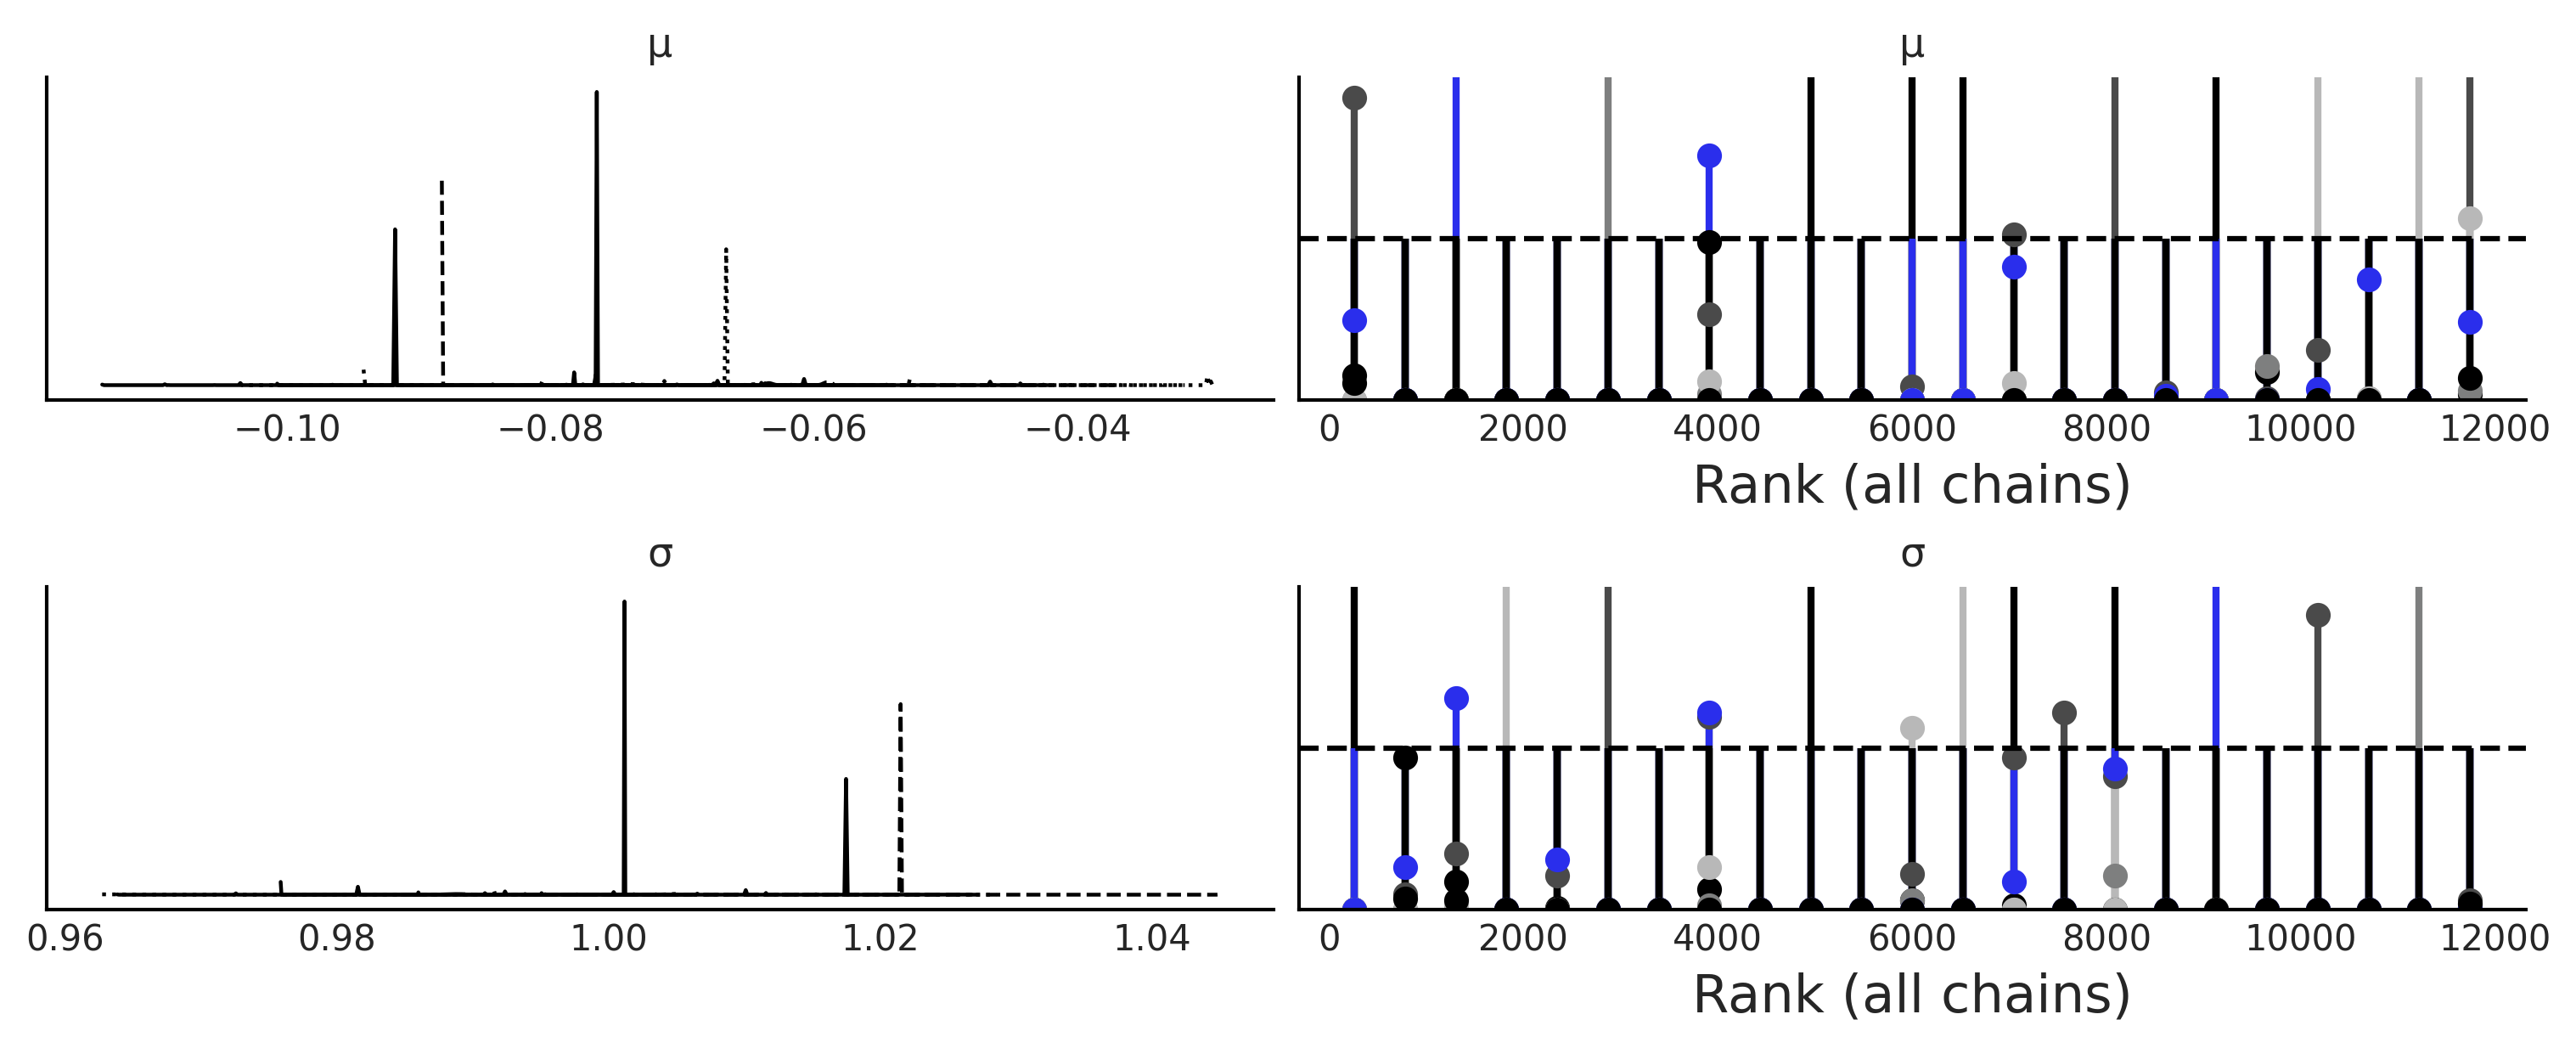

In [16]:
az.plot_trace(trace_g_001, kind="rank_vlines", figsize=(10, 4));
# plt.savefig("img/chp08/trace_g_eps_too_low.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

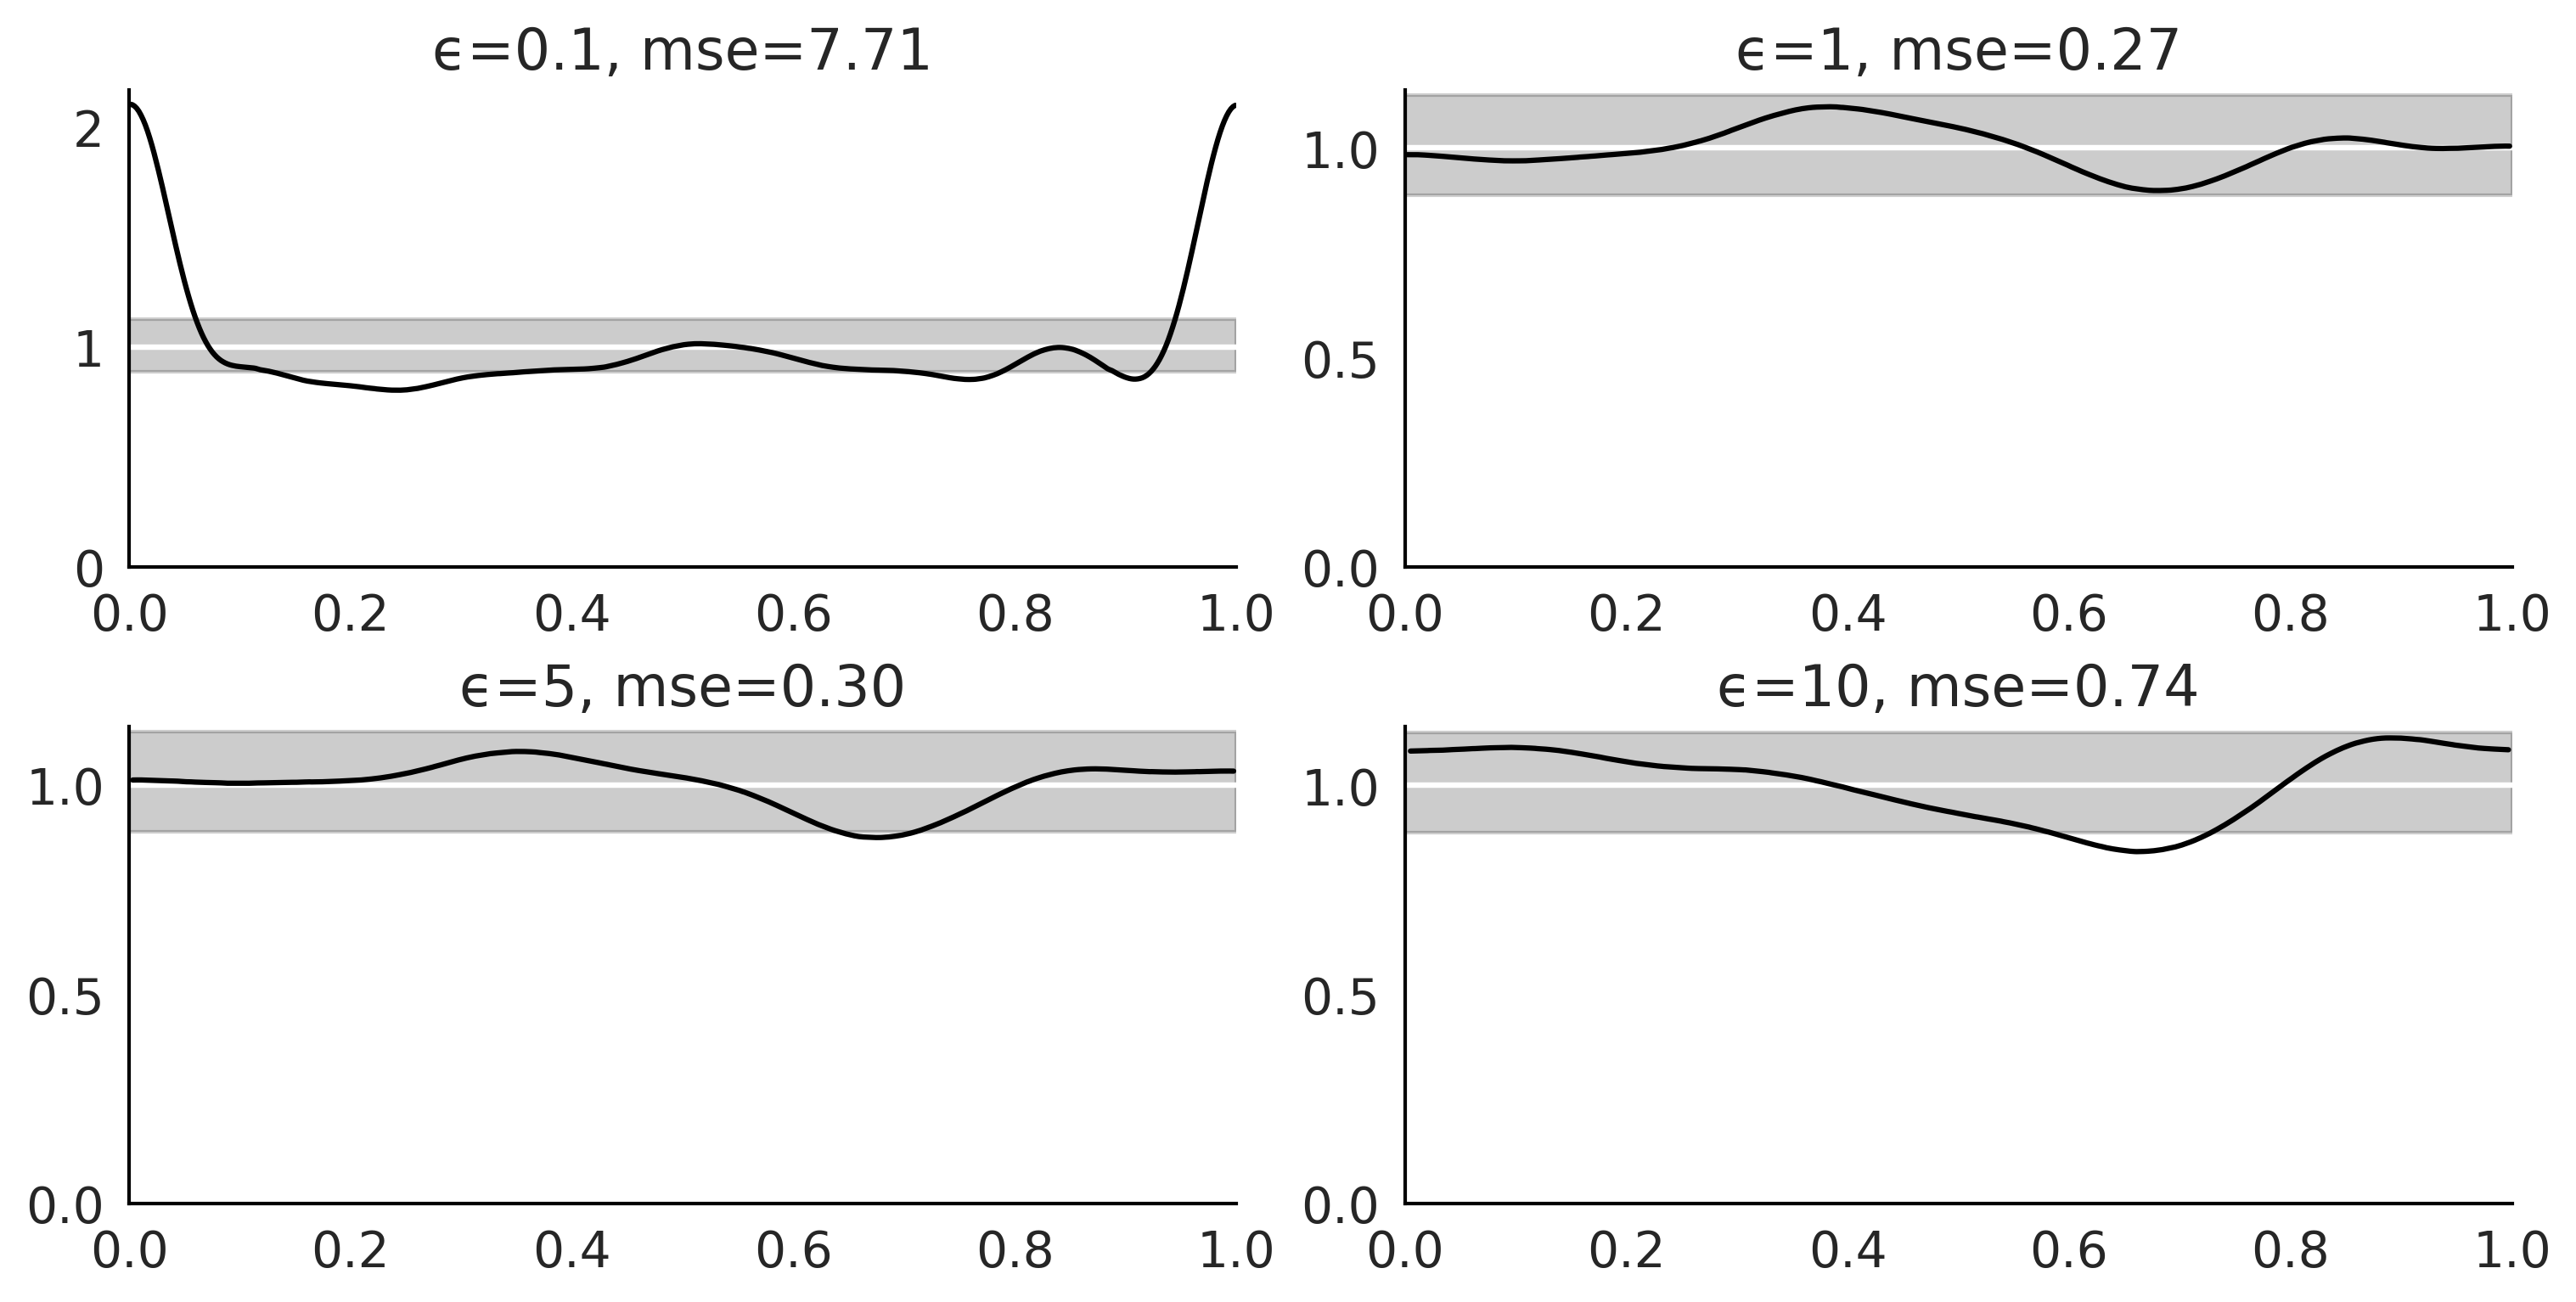

In [17]:
traces_ = [trace_g_001, trace_g_01, trace_g_05, trace_g_10]
sim_data_ = [sim_data_001, sim_data_01, sim_data_05, sim_data_10]
epsilons = [0.1, 1, 5, 10]

_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    #pp_vals = np.reshape(sim_data_[i]["s"], (8000, -1))
    pp_vals = np.reshape(sim_data_[i]["s"], (12000, -1)) # n_chains x n_draws

    tstat_pit = np.mean(pp_vals <= data, axis=0)
    _, tstat_pit_dens = az.kde(tstat_pit)
    
    ax.axhline(1, color="w")
    az.plot_bpv(dada, kind="u_value", ax=ax, reference="analytical")
    ax.tick_params(axis='both', pad=7)
    ax.set_title(f"ϵ={epsilons[i]}, mse={np.mean((1 - tstat_pit_dens)**2) * 100:.2f}")

# plt.savefig("img/chp08/bpv_g_many_eps_00.png")
plt.show();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

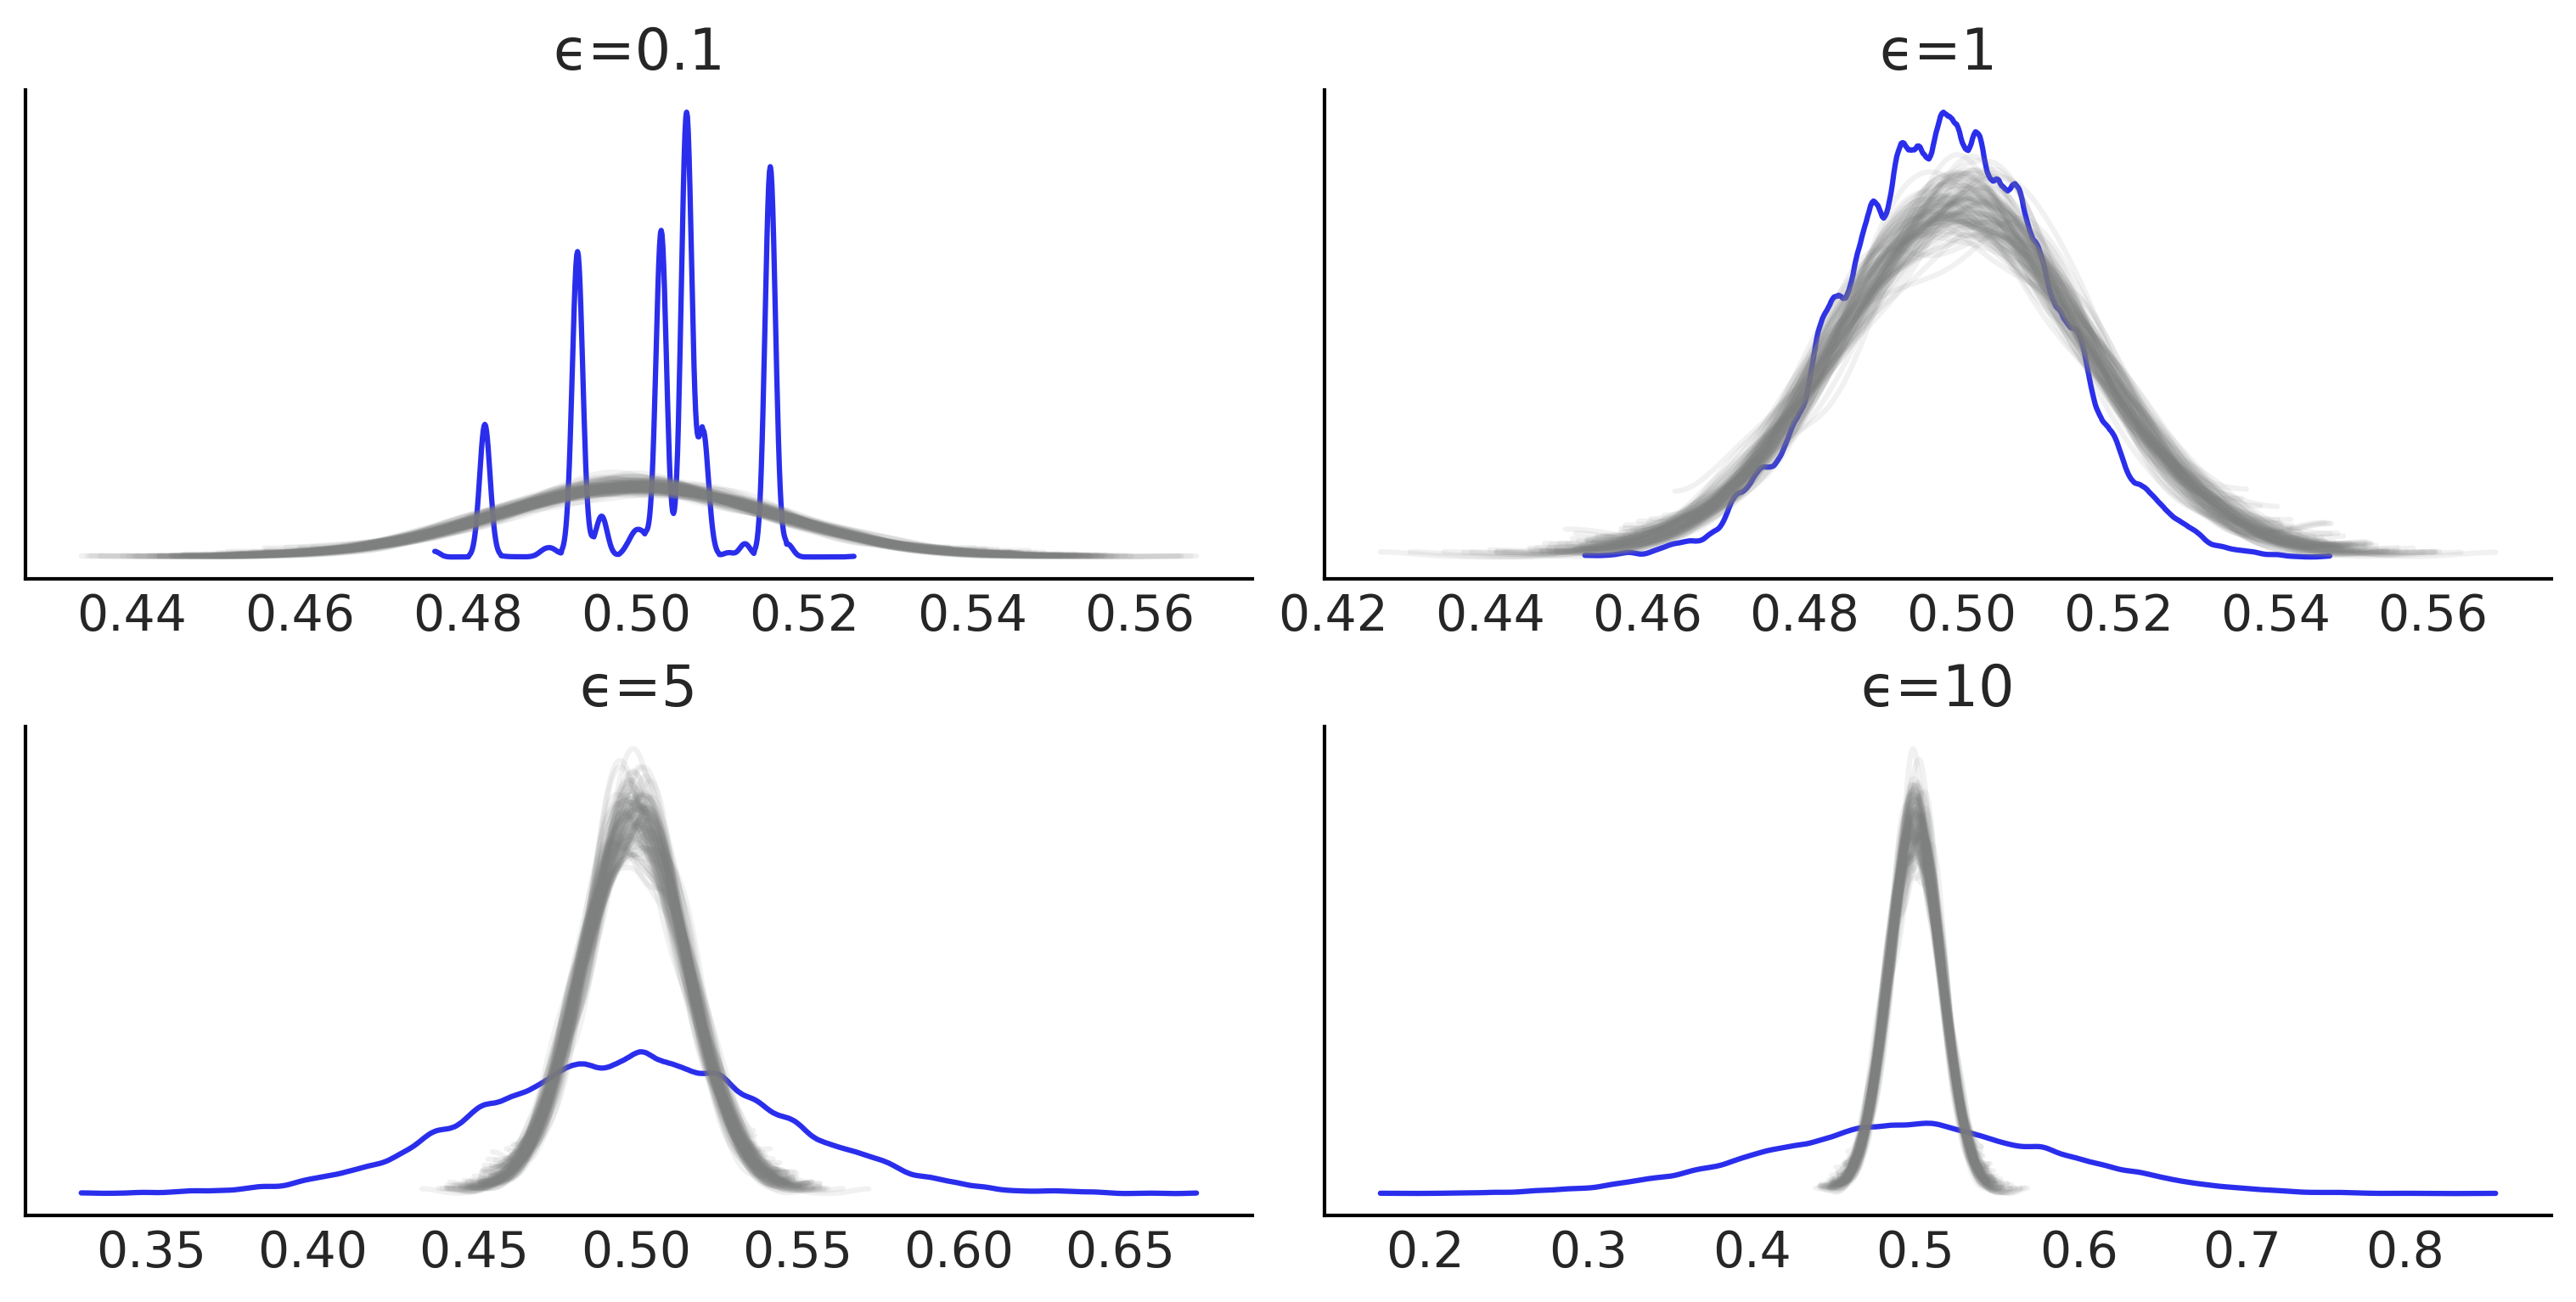

In [18]:
_, ax = plt.subplots(2, 2, figsize=(10,5))

ax = ax.ravel()
for i in range(4):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    az.plot_bpv(dada, kind="p_value", reference='samples', color="C4", ax=ax[i],
               plot_ref_kwargs={"color":"C2"})
    ax[i].set_title(f"ϵ={epsilons[i]}")
# plt.savefig("img/chp08/bpv_g_many_eps_01.png")
plt.show();

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pym

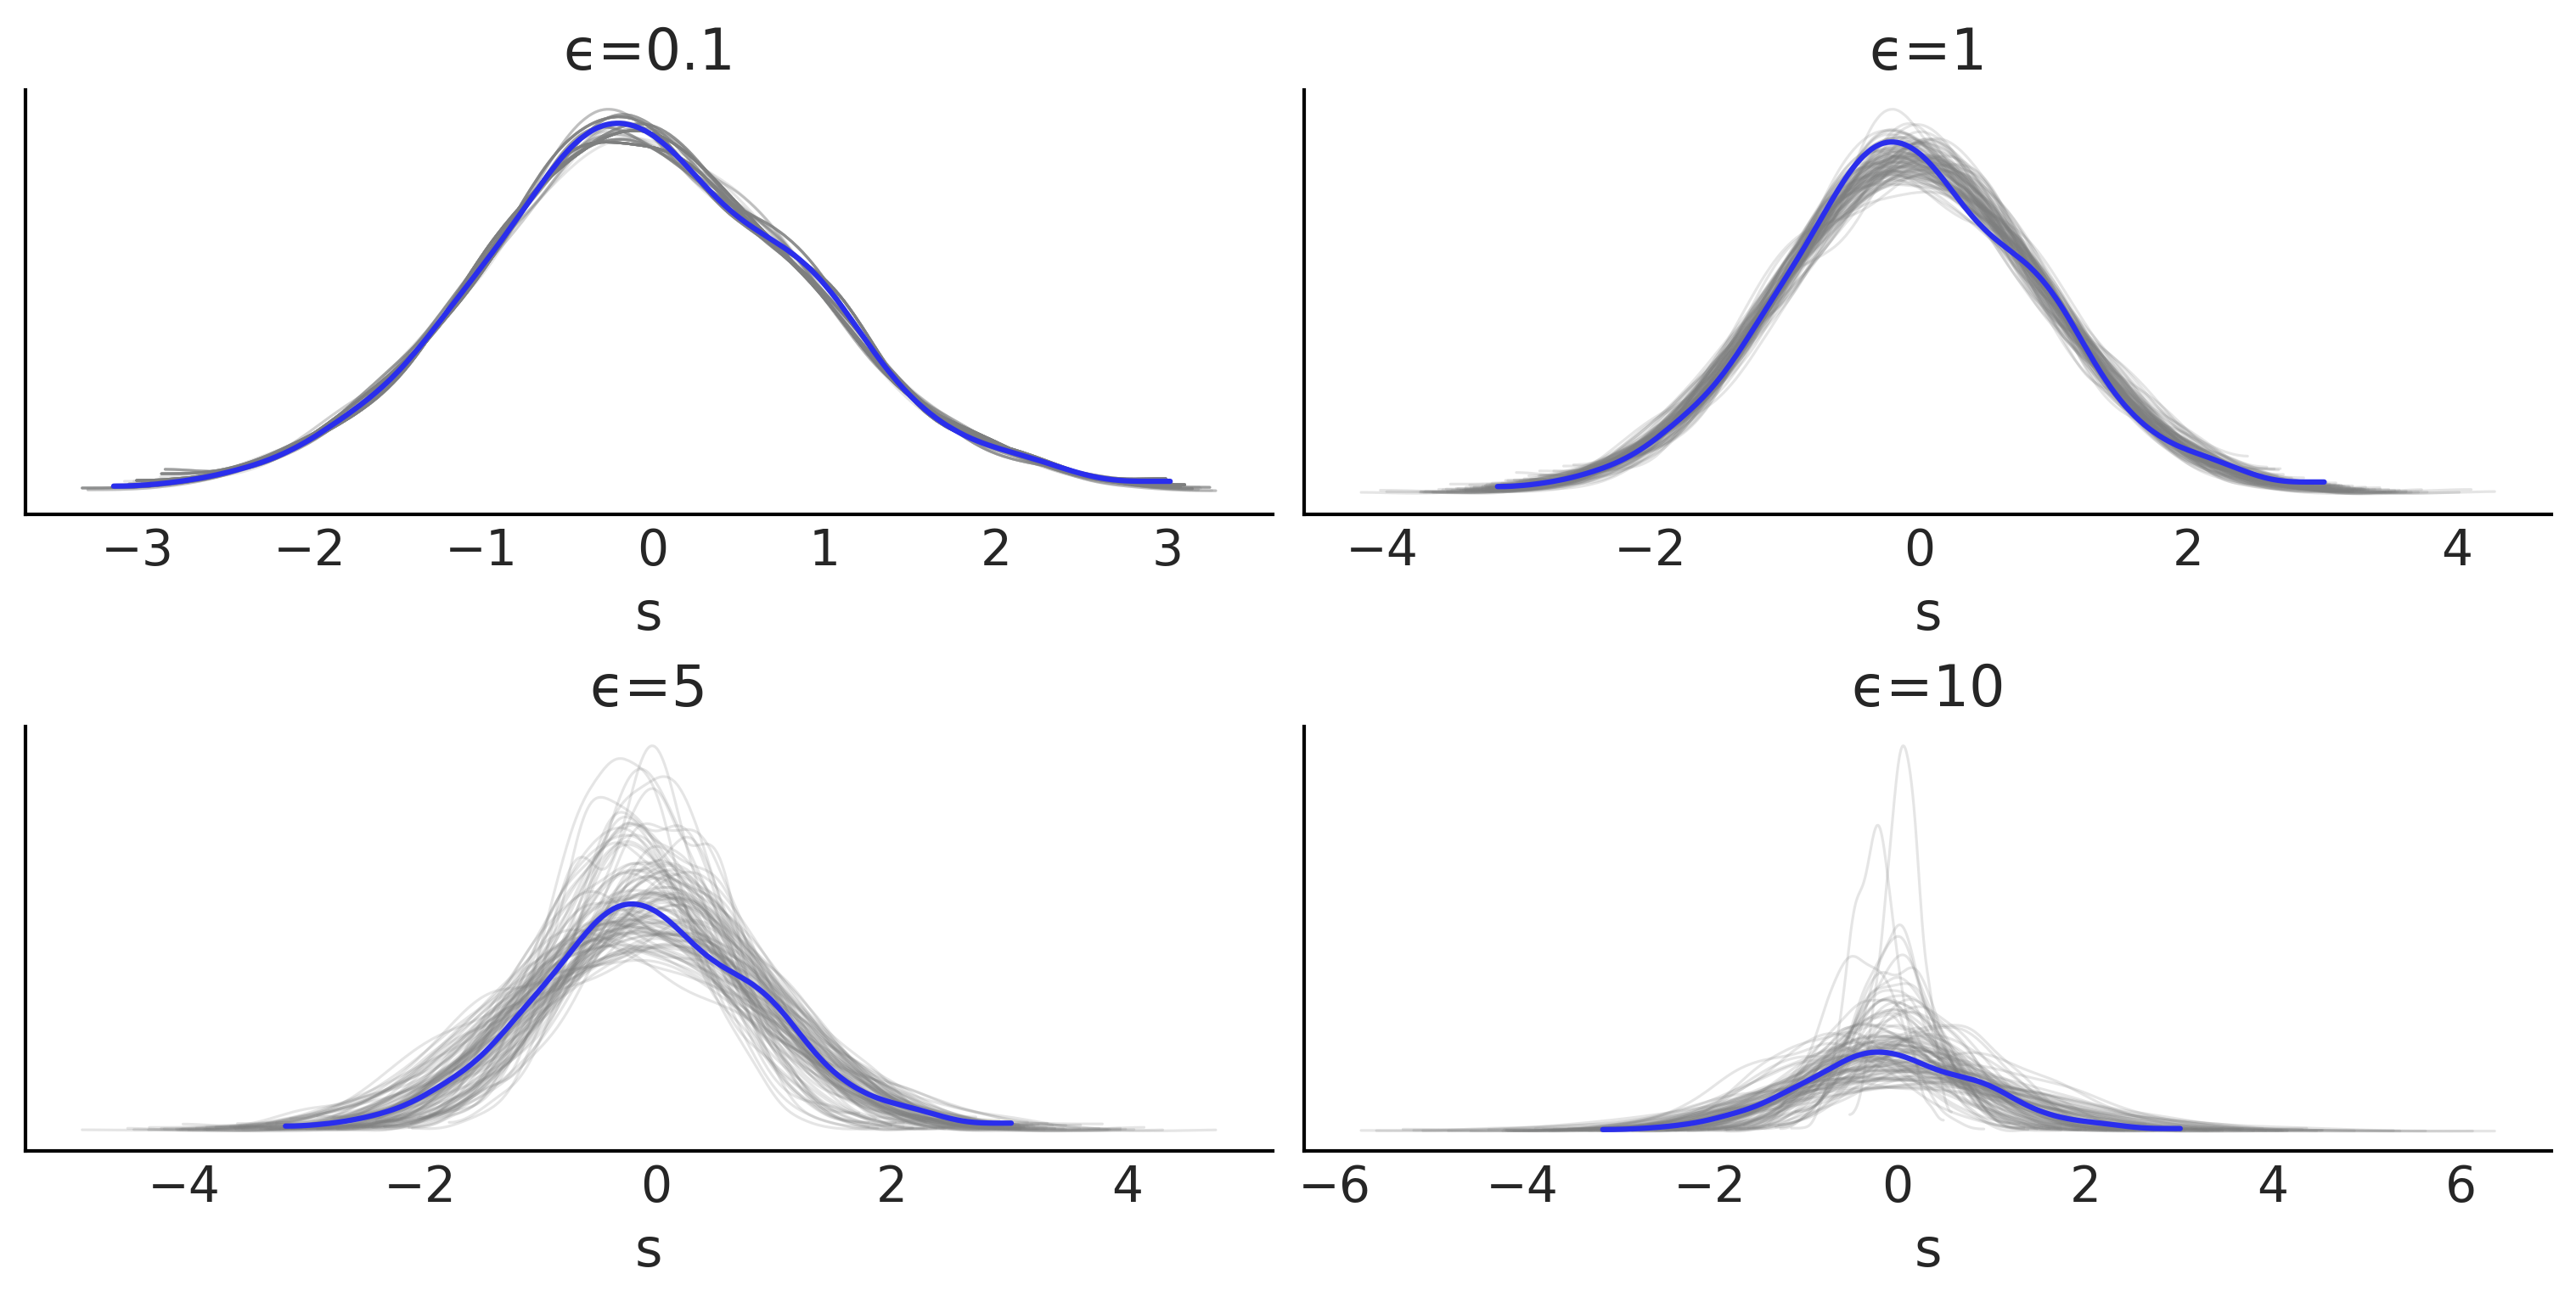

In [19]:
_, axes = plt.subplots(2, 2, figsize=(10,5))

for i, ax in enumerate(axes.ravel()):
    dada = az.from_pymc3(traces_[i], 
                         posterior_predictive=sim_data_[i])

    az.plot_ppc(dada, num_pp_samples=100, ax=ax, color="C2",
                mean=False, legend=False, observed=False)
    az.plot_kde(dada.observed_data["s"], plot_kwargs={"color":"C4"}, ax=ax)
    ax.set_xlabel("s")
    ax.set_title(f"ϵ={epsilons[i]}")
# plt.savefig("img/chp08/ppc_g_many_eps.png")
plt.show()

## 8.5 g-and-k distributions

### Figure 8.9

In [20]:
data = pd.read_csv("data/air_pollution_bsas.csv")
bsas_co = data["co"].dropna().values
bsas_co

array([0.539     , 0.669     , 0.3225    , ..., 0.63458333, 0.7125    ,
       0.4975    ])

In [21]:
print(bsas_co.shape)
# Without extreme right tail values
bsas_ = bsas_co[bsas_co < 3.0]
print(bsas_.shape)

(2484,)
(2476,)


'We have 8 observations larger than 3 ppm'

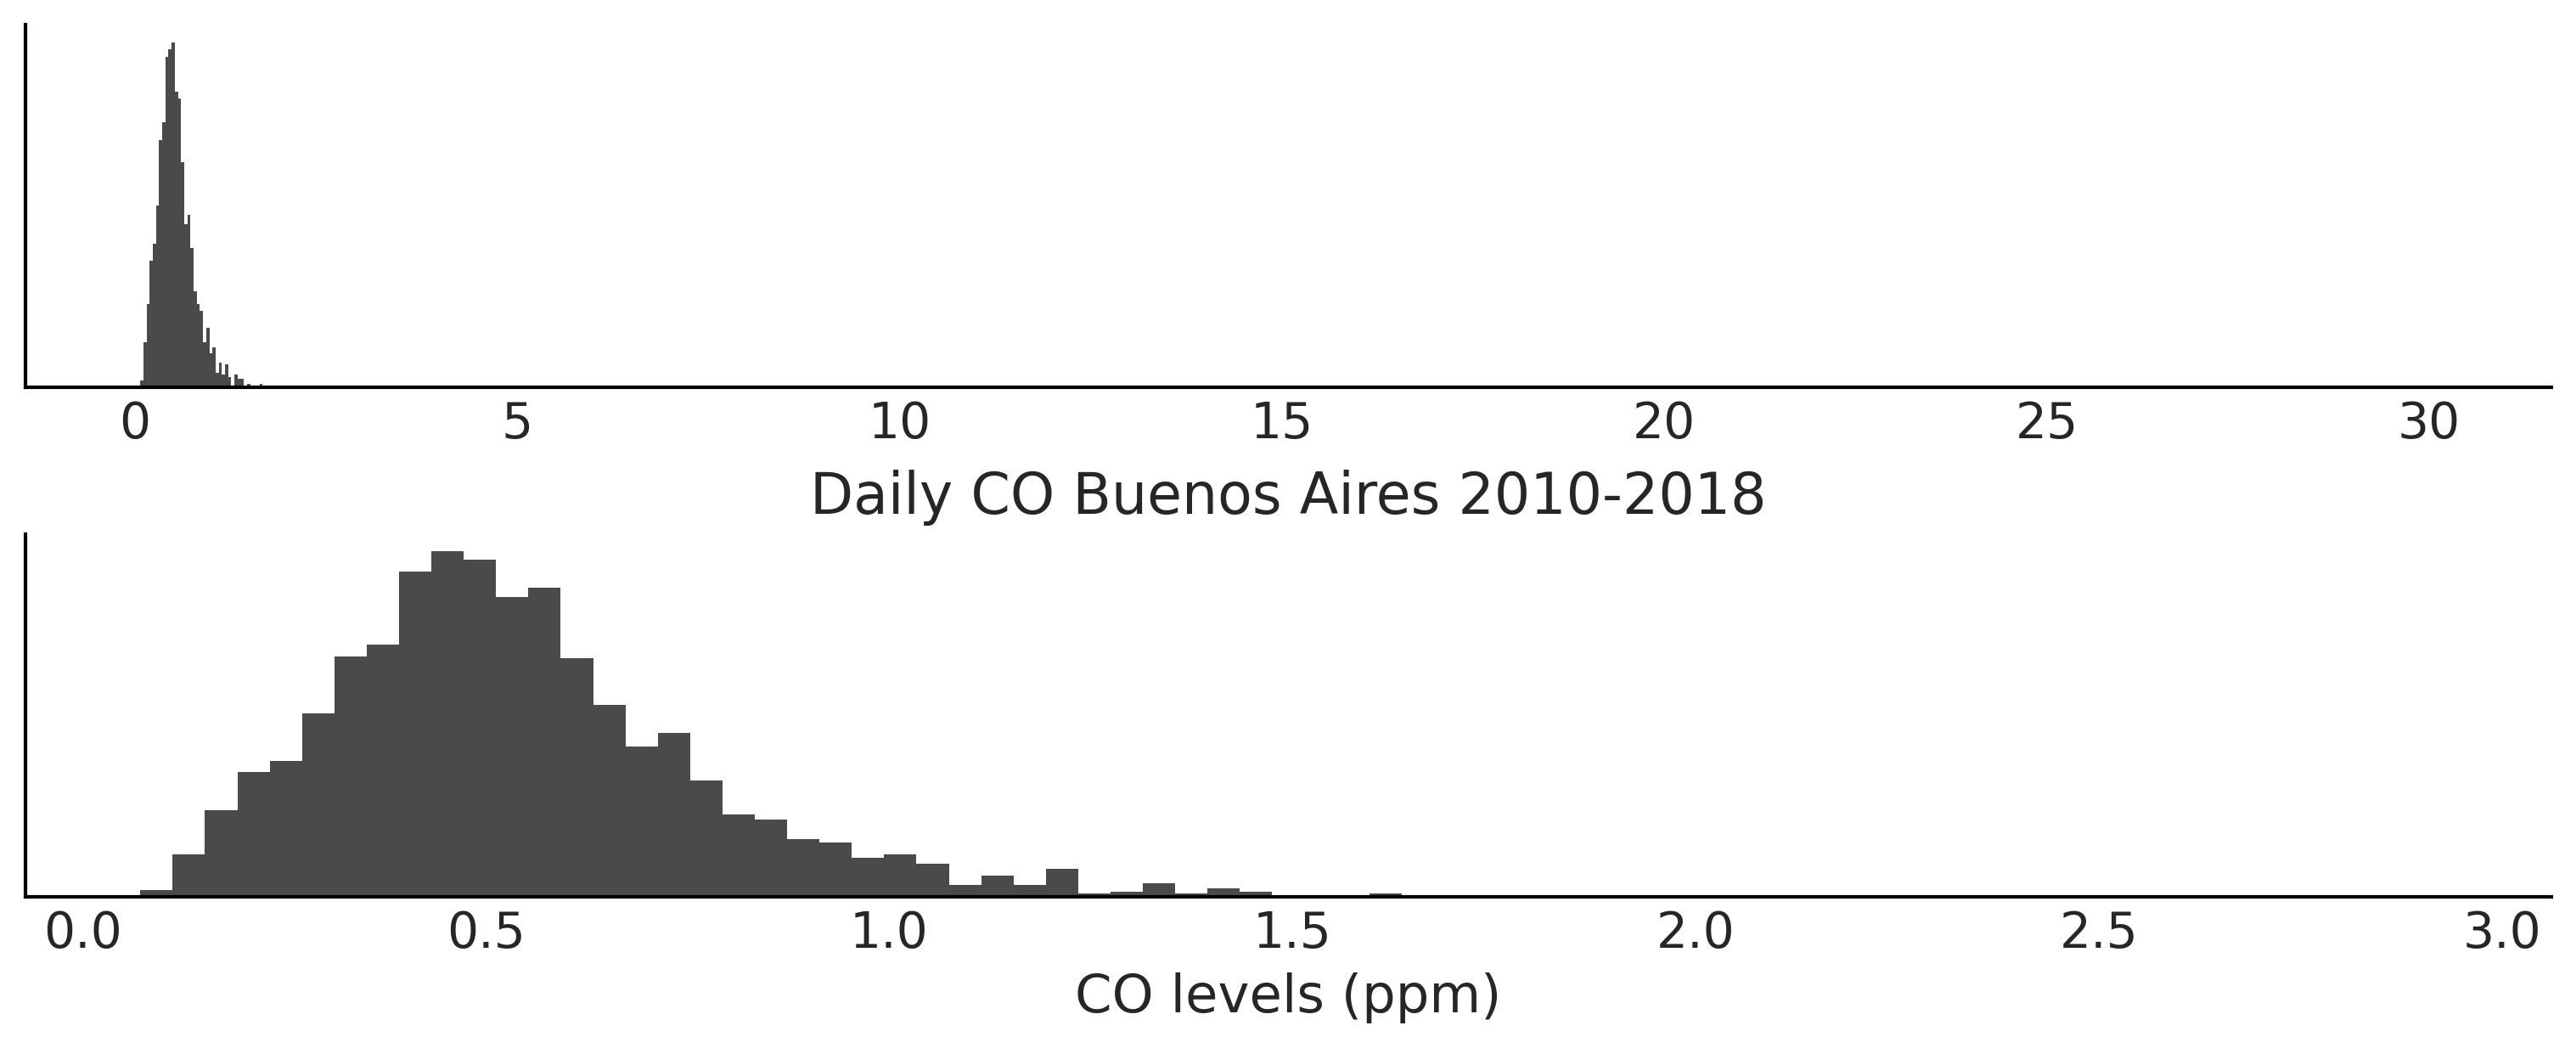

In [22]:
_, axes = plt.subplots(2,1,  figsize=(10,4), sharey=True)
axes[0].hist(bsas_co, bins="auto", color="C1", density=True)
axes[0].set_yticks([])
axes[1].hist(bsas_co[bsas_co < 3], bins="auto", color="C1", density=True)
axes[1].set_yticks([])
axes[1].set_xlabel("CO levels (ppm)")
# plt.savefig("img/chp08/co_ppm_bsas.png")
plt.title('Daily CO Buenos Aires 2010-2018')
f"We have {sum(bsas_co > 3)} observations larger than 3 ppm"

### Code 8.4 and Figure 8.10

In [23]:
class g_and_k_quantile:
    def __init__(self):
        self.quantile_normal = stats.norm(0, 1).ppf
        self.pdf_normal = stats.norm(0, 1).pdf

    def ppf(self, x, a, b, g, k):
        z = self.quantile_normal(x)
        return a + b * (1 + 0.8 * np.tanh(g*z/2)) * ((1 + z**2)**k) * z

    
    def rvs(self, samples, a, b, g, k):
        x = np.random.uniform(0, 1, samples)
        return self.ppf(x, a, b, g, k)

    def cdf(self, x, a, b, g, k, zscale=False):   
        optimize.fminbound(f, -5, 5)

    def pdf(self, x, a, b, g, k):
        #z = cdf(x, a, b, g, k)
        z = x
        z_sq = z**2
        term1 = (1+z_sq)**k
        term2 = 1+0.8*np.tanh(g*x/2)
        term3 = (1+(2*k+1)*z_sq)/(1+z_sq)
        term4 = 0.8*g*z/(2*np.cosh(g*z/2)**2)

        deriv = b*term1*(term2*term3+term4)
        return self.pdf_normal(x) / deriv

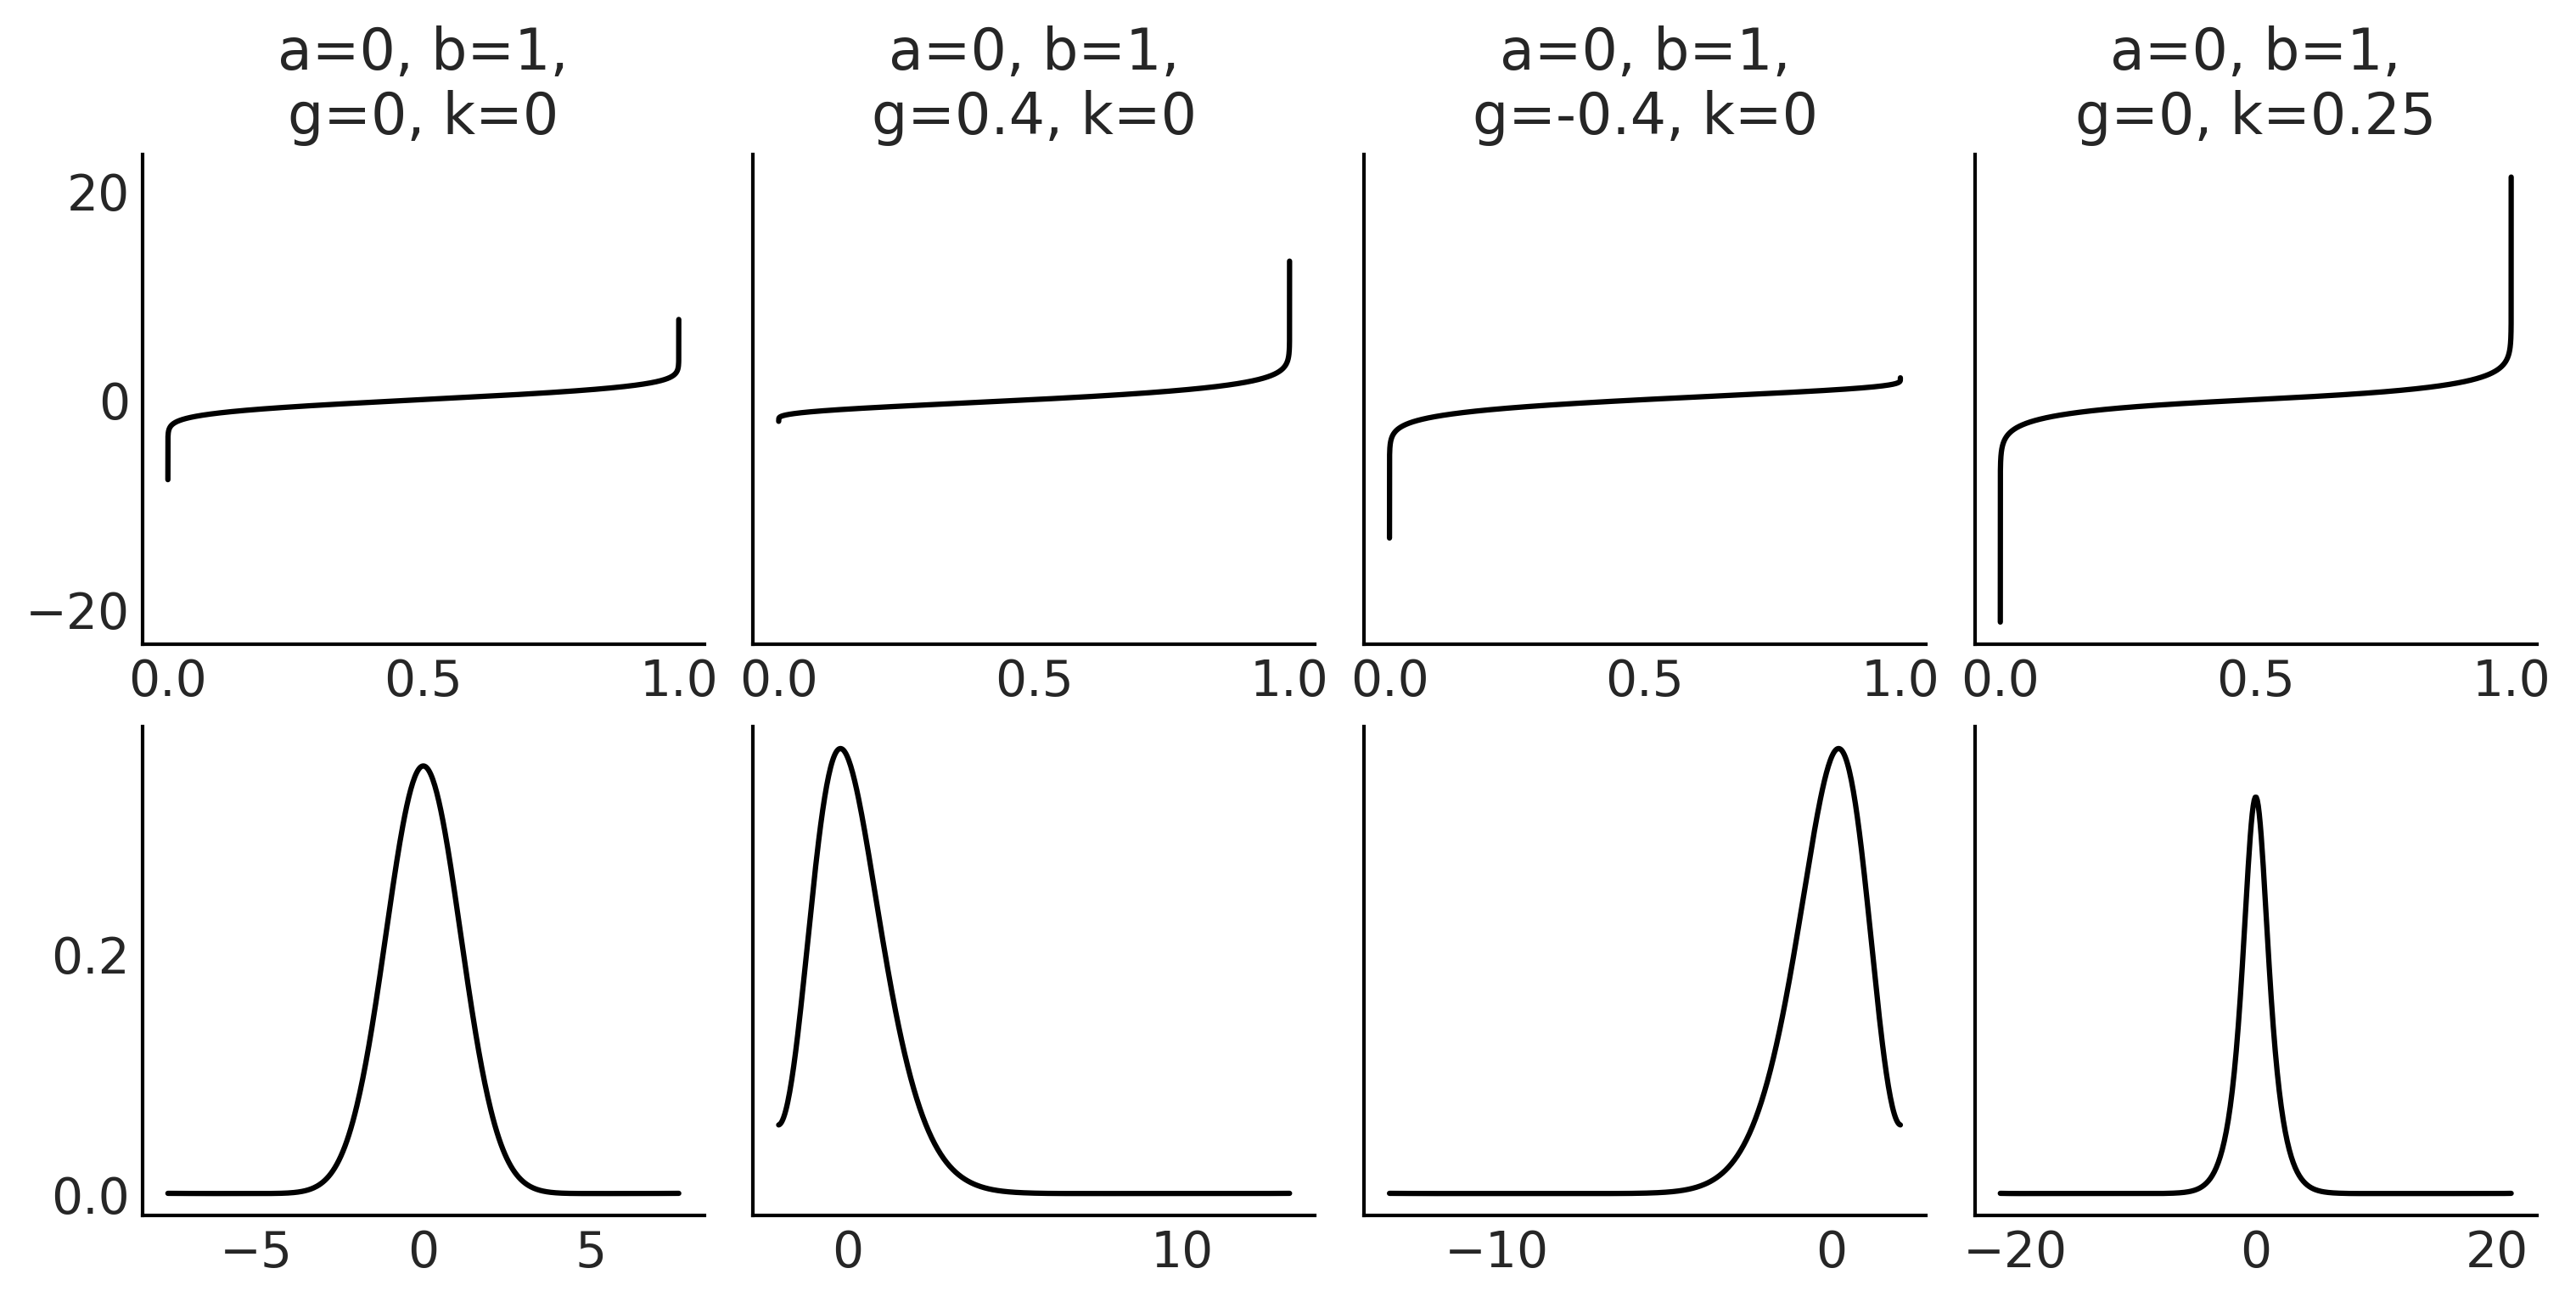

In [24]:
gk = g_and_k_quantile()
u = np.linspace(1E-14, 1-1E-14, 10000)

params = ((0, 1, 0, 0), 
 (0, 1, .4, 0),
 (0, 1,-.4, 0),
 (0, 1, 0, 0.25))

_, ax = plt.subplots(2, 4, sharey="row", figsize=(10, 5))
for i, p in enumerate(params):
    a, b, g, k = p
    ppf = gk.ppf(u, a, b, g, k)
    ax[0, i].plot(u, ppf)
    ax[0, i].set_title(f"a={a}, b={b},\ng={g}, k={k}")
    #ax[1, i].plot(x, gk.pdf(x, a, b, g, k))
    az.plot_kde(ppf, ax=ax[1, i], bw=0.5)
# plt.savefig("img/chp08/gk_quantile.png")

### Code 8.5

In [25]:
def octo_summary(x):
    e1, e2, e3, e4, e5, e6, e7 = np.quantile(x, [0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875])
    sa = e4
    sb = e6 - e2
    sg = (e6 + e2 - 2*e4)/sb
    sk = (e7 - e5 + e3 - e1)/sb
    return np.array([sa, sb, sg, sk])

### Code 8.6

In [26]:
gk = g_and_k_quantile()
def gk_simulator(a, b, g, k):
    return gk.rvs(len(bsas_co), a, b, g, k)

### Code 8.7 and Figure 8.11

In [27]:
with pm.Model() as gkm:
    a = pm.HalfNormal('a', sd=1)
    b = pm.HalfNormal('b', sd=1)
    g = pm.HalfNormal('g', sd=1)
    k = pm.HalfNormal('k', sd=1)
    
    s = pm.Simulator('s', gk_simulator, params=[a, b, g, k],        
                     sum_stat=octo_summary,
                     epsilon=0.1,
                     observed=bsas_co)
    
    trace_gk, sim_data_gk = pm.sample_smc(kernel="ABC",
                                          parallel=True,
                                          save_sim_data=True,
                                          )

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.013
Stage:   1 Beta: 0.069
Stage:   2 Beta: 0.240
Stage:   3 Beta: 0.672
Stage:   4 Beta: 1.000


In [28]:
az.summary(trace_gk)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a  0.503  0.099   0.317    0.687      0.001    0.001   11778.0   12151.0   
b  0.194  0.071   0.064    0.329      0.001    0.000   11750.0   11855.0   
g  0.452  0.286   0.006    0.950      0.003    0.002   11646.0   11723.0   
k  0.145  0.088   0.002    0.296      0.001    0.001   11876.0   12193.0   

   r_hat  
a    1.0  
b    1.0  
g    1.0  
k    1.0

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


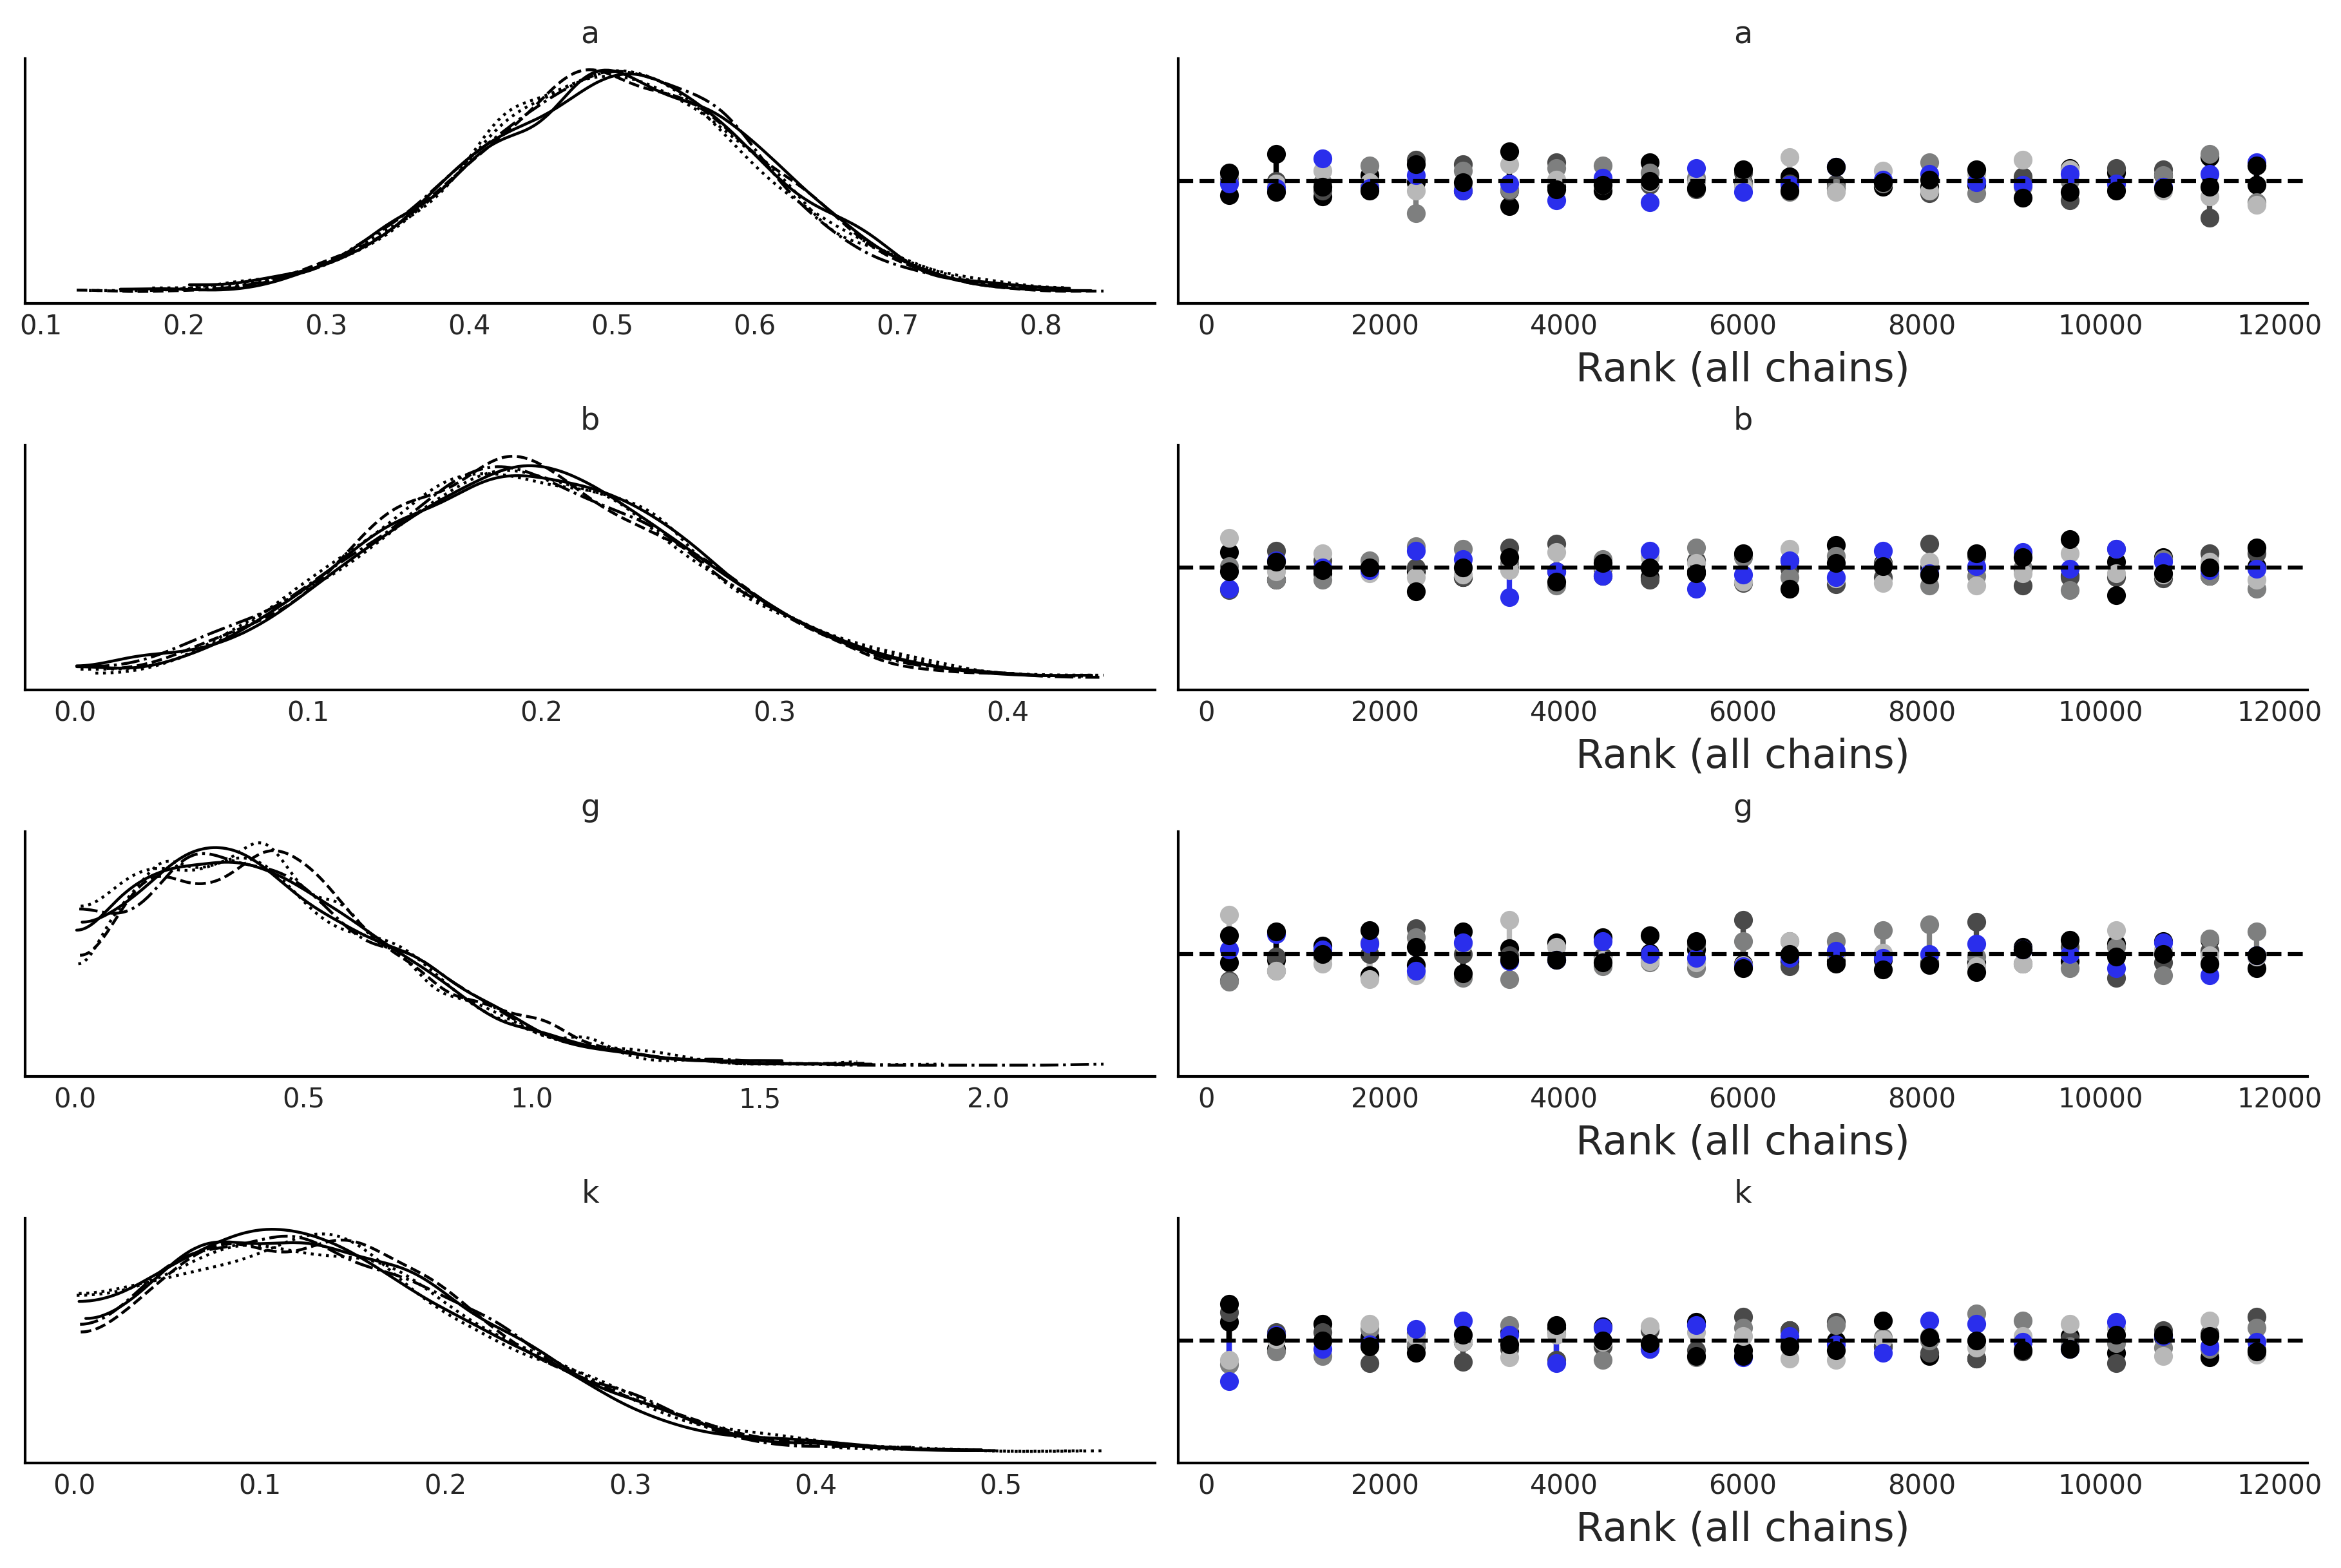

In [29]:
az.plot_trace(trace_gk, kind="rank_vlines");
# plt.savefig("img/chp08/trace_gk.png")

In [30]:
axes = az.plot_pair(trace_gk, 
                    kind="kde", 
                    marginals=True,
                    textsize=45,
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    )

for ax, pad in zip(axes[:,0], (70, 30, 30, 30)):
    ax.set_ylabel(ax.get_ylabel(), rotation=0, labelpad=pad)

# plt.savefig("img/chp08/pair_gk.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


## 8.6 Approximating moving averages

### Code 8.8 and Figure 8.12

In [31]:
def moving_average_2(θ1, θ2, n_obs=200):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

We are calling the simulator one more time to generate "observed data".

In [32]:
θ1_true = 0.7
θ2_true = 0.3
y_obs = moving_average_2(θ1_true, θ2_true)

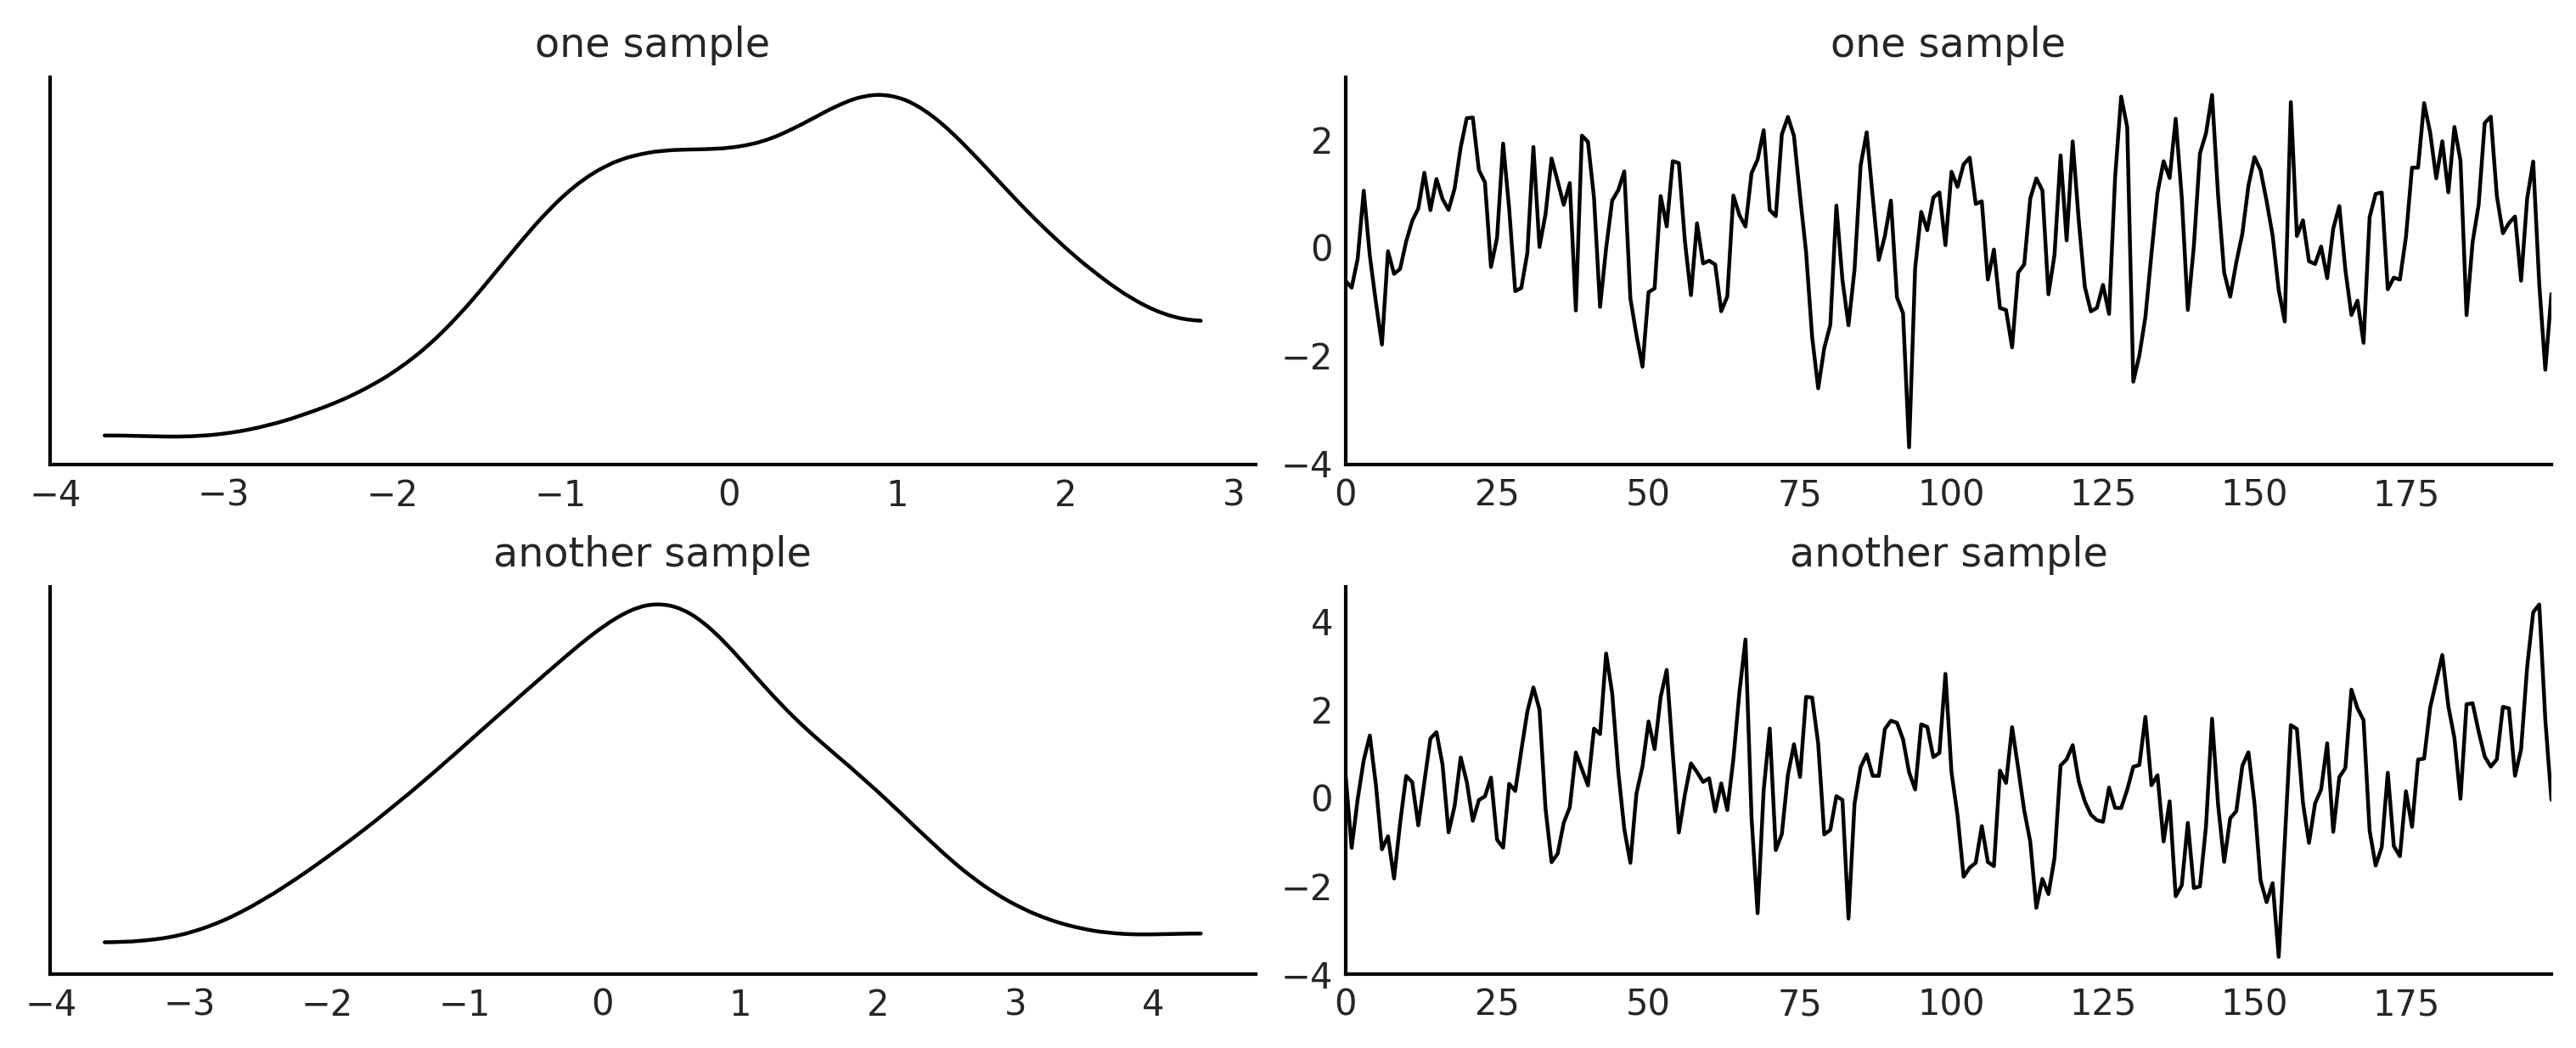

In [33]:
az.plot_trace({'one sample':moving_average_2(θ1_true, θ2_true),
               'another sample':moving_average_2(θ1_true, θ2_true)},
              trace_kwargs={'alpha':1},
              figsize=(10, 4)
             );
# plt.savefig("img/chp08/ma2_simulator_abc.png")

### Code 8.9

In [34]:
def autocov(x):
    a = np.mean(x[1:] * x[:-1])
    b = np.mean(x[2:] * x[:-2])
    return np.array((a, b))

### Code 8.10 and Figure 8.13

In [35]:
# https://github.com/pymc-devs/pymc/issues/1463#issuecomment-258675231 ???????????????????
# # [global]
# config.compile.timeout = 1000

In [36]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(draws=3000, kernel="ABC", parallel=True, chains=4)

Initializing SMC sampler...
Sampling 4 chains in 6 jobs
Potentials will be added to the prior term
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarni

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'θ1'}>,
        <AxesSubplot:title={'center':'θ1'}, xlabel='Rank (all chains)'>],
       [<AxesSubplot:title={'center':'θ2'}>,
        <AxesSubplot:title={'center':'θ2'}, xlabel='Rank (all chains)'>]],
      dtype=object)

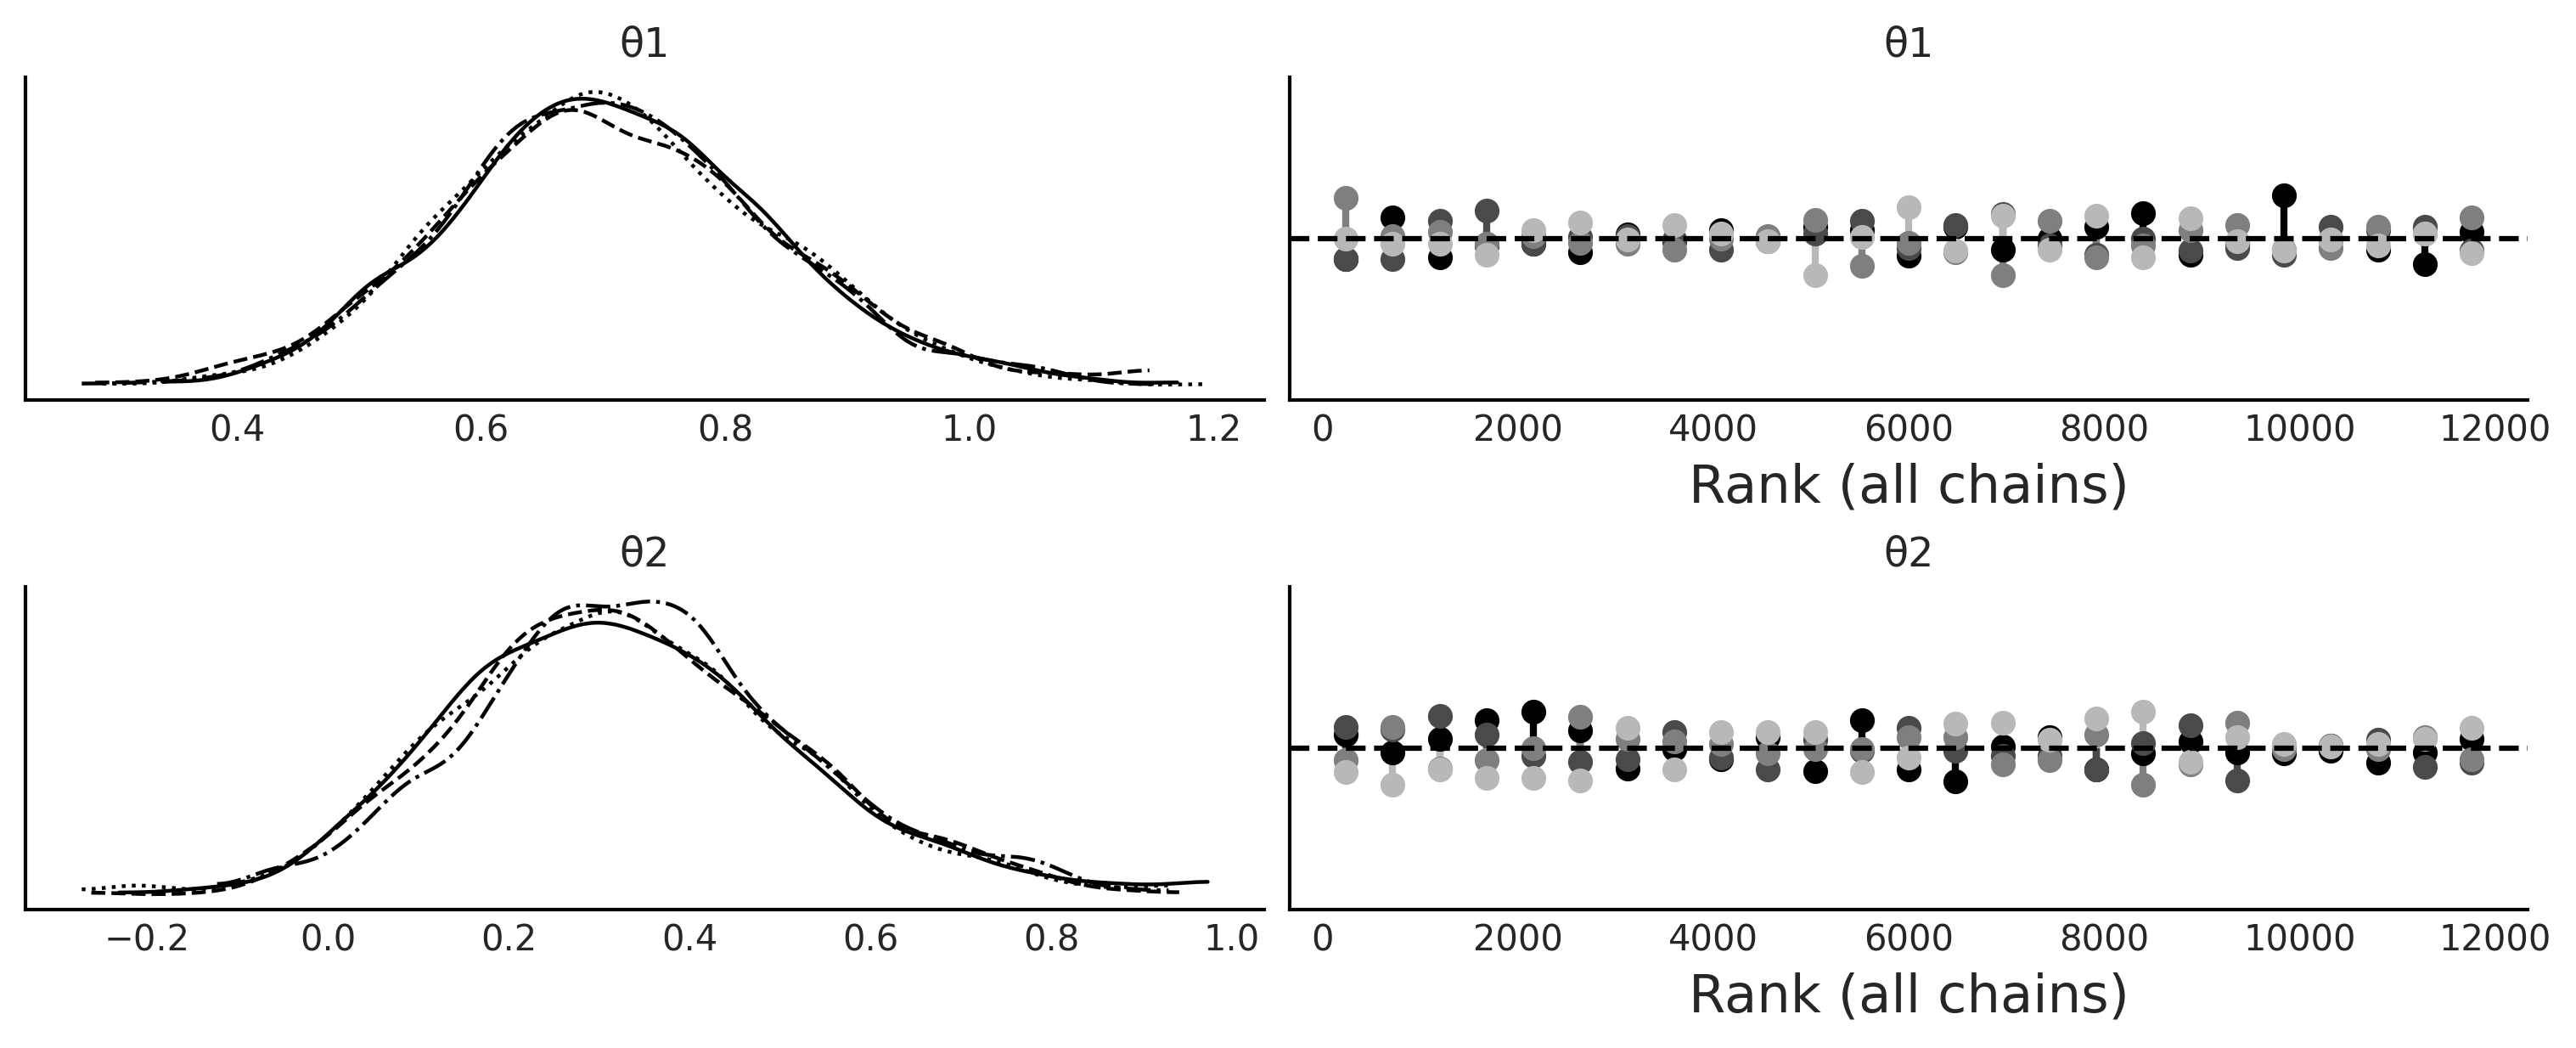

In [37]:
az.plot_trace(trace_ma2, kind="rank_vlines", figsize=(10, 4))
# plt.savefig("img/chp08/ma2_trace.png")

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


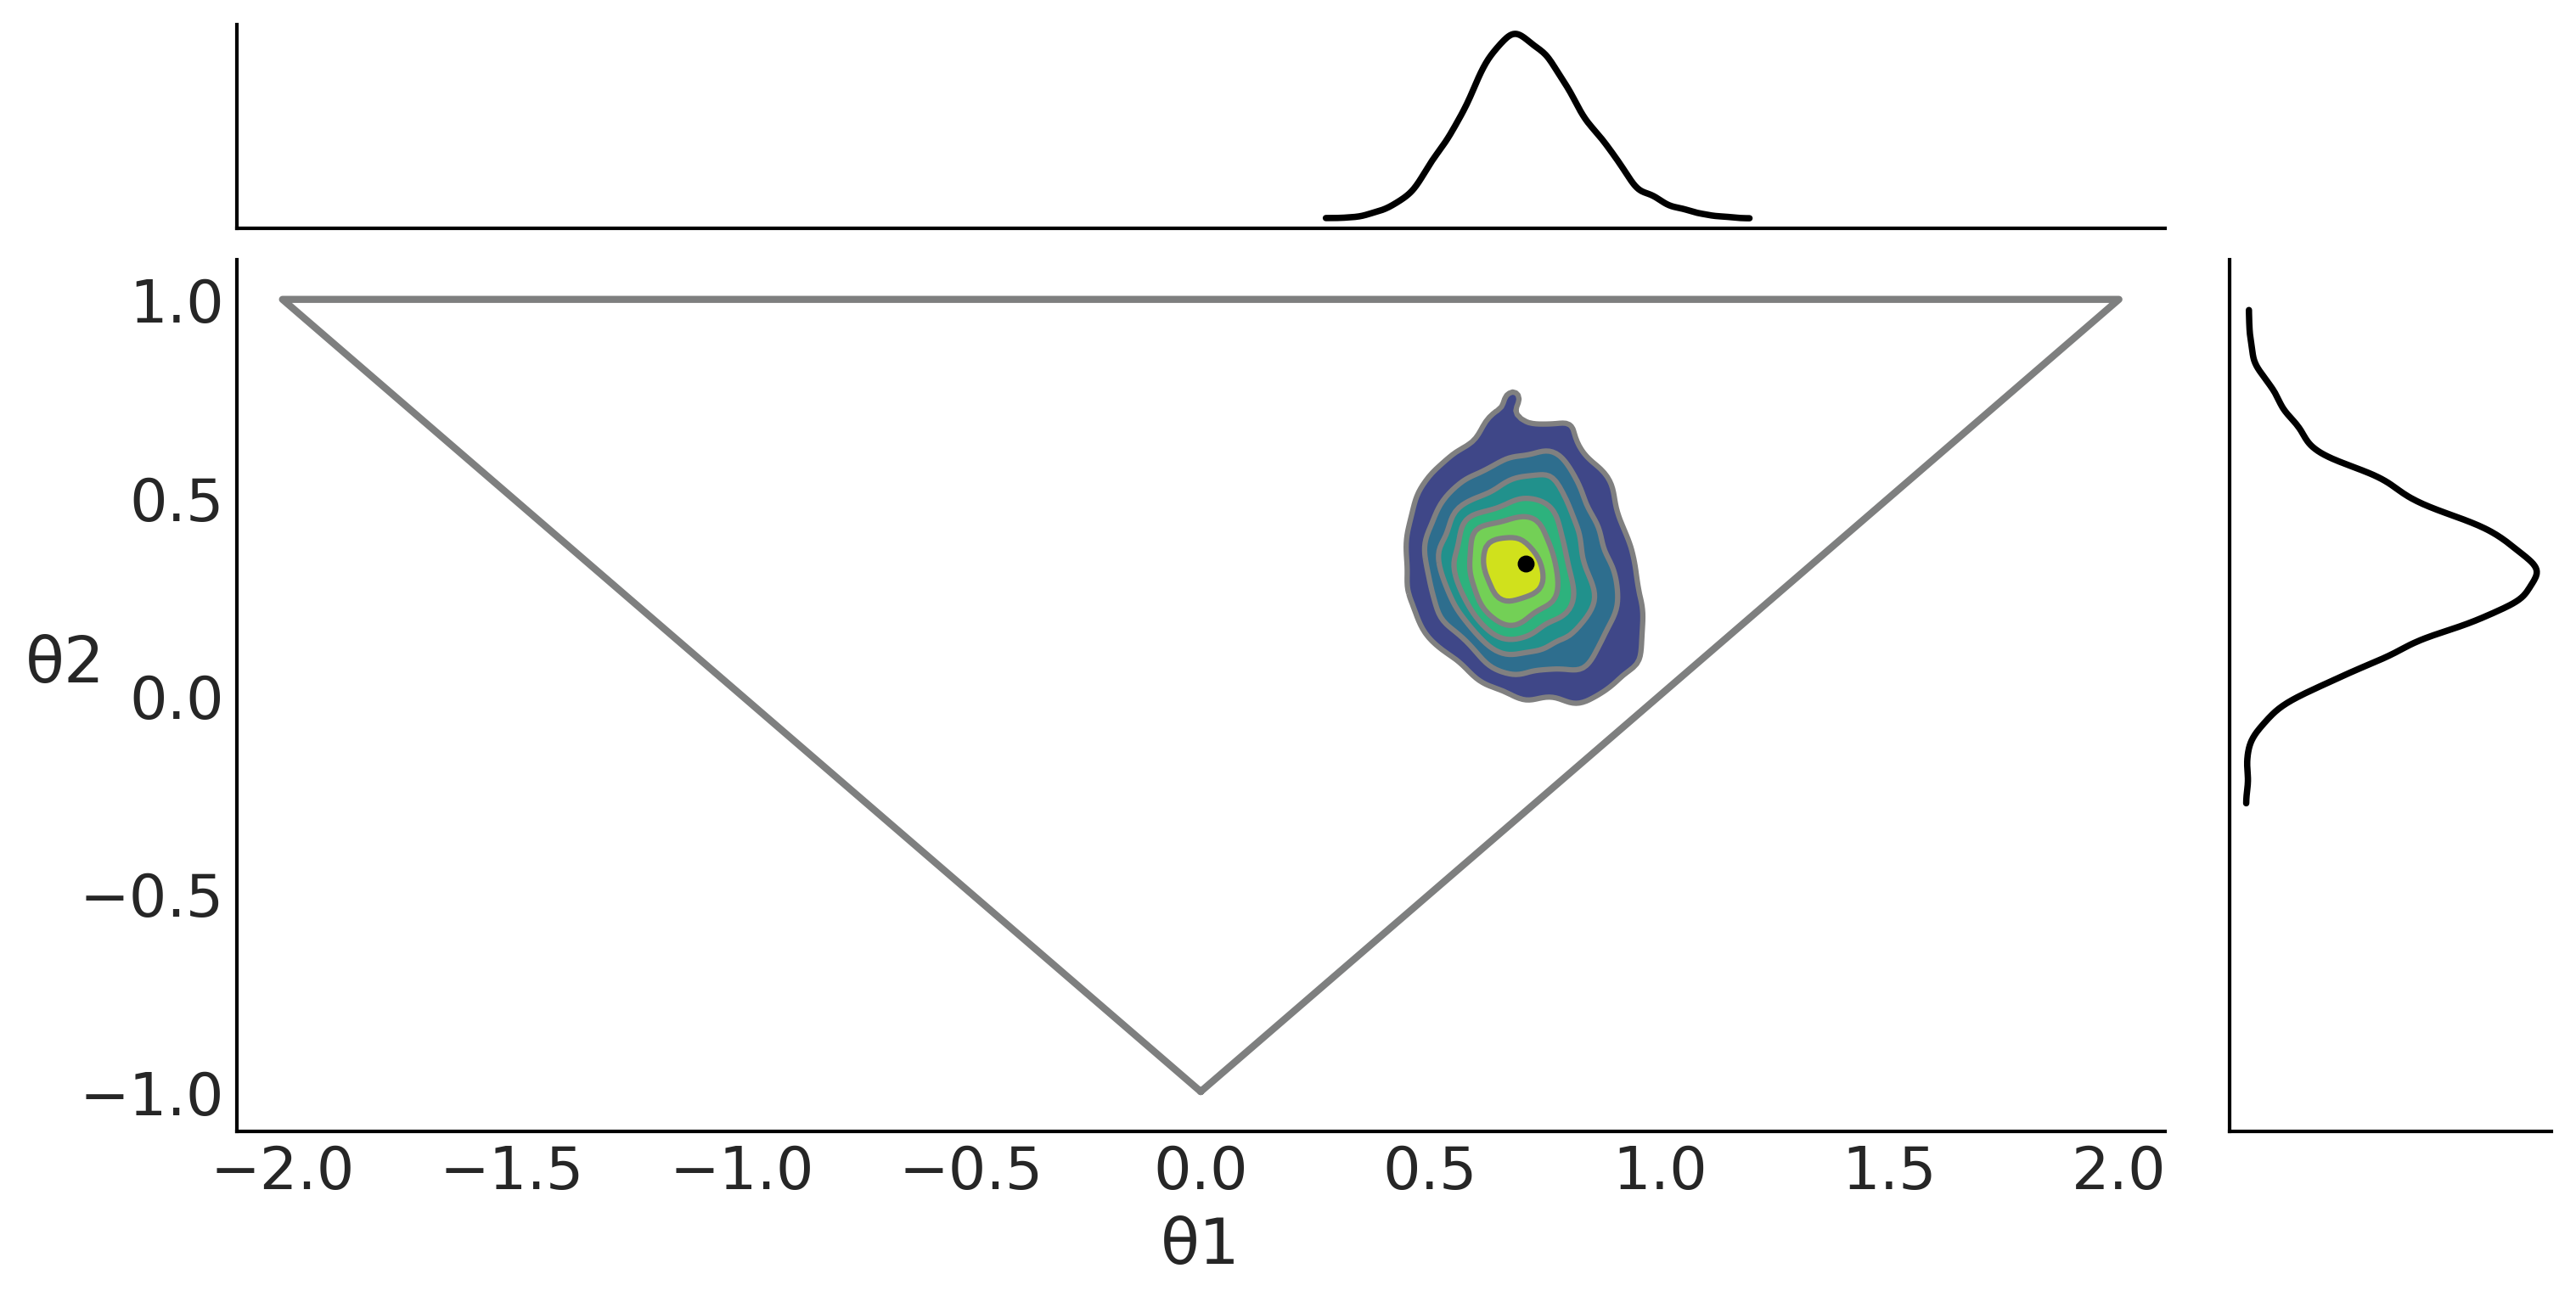

In [38]:
#ax = az.plot_pair(t_p, var_names=["θ1", "θ2"], marginals=True)
axes = az.plot_pair(trace_ma2, kind="kde", var_names=["θ1", "θ2"],
                    marginals=True, figsize=(10,5),
                    kde_kwargs={"contourf_kwargs":{"cmap":plt.cm.viridis}},
                    point_estimate="mean",
                    point_estimate_kwargs={"ls":"none"},
                    point_estimate_marker_kwargs={"marker":".",
                                                  "facecolor":"k",
                                                  "zorder":2})

axes[1,0].set_xlim(-2.1, 2.1)
axes[1,0].set_ylim(-1.1, 1.1)
axes[1,0].set_ylabel(axes[1,0].get_ylabel(), rotation=0)
axes[1,0].plot([0, 2, -2, 0], [-1, 1, 1, -1], "C2", lw=2)
# plt.savefig("img/chp08/ma2_triangle.png")

## Model Comparison in the ABC context

To reproduce the figures in the book, run `loo_abc.py`

##  Model choice via random forest

In [39]:
def moving_average_1(θ1, n_obs=500):
    λ = np.random.normal(0, 1, n_obs+1)
    y = λ[2:] + θ1*λ[1:-1]
    return y

def moving_average_2(θ1, θ2, n_obs=500):
    λ = np.random.normal(0, 1, n_obs+2)
    y = λ[2:] + θ1*λ[1:-1] + θ2*λ[:-2]
    return y

θ1_true = 0.7
θ2_true = 0.3
y_obs = moving_average_2(θ1_true, θ2_true)

In [40]:
def autocov(x, n=2):
    return np.array([np.mean(x[i:] * x[:-i]) for i in range(1, n+1)])

### Code 8.12

In [41]:
with pm.Model() as model_ma1:
    θ1 = pm.Uniform('θ1', -1, 1)
    y = pm.Simulator('y', moving_average_1,
                     params=[θ1], sum_stat=autocov, epsilon=0.1, observed=y_obs)
    trace_ma1 = pm.sample_smc(3000, kernel="ABC", parallel=True)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Stage:   0 Beta: 0.026
Stage:   1 Beta: 0.118
Stage:   2 Beta: 0.315
Stage:   3 Beta: 0.670
Stage:   4 Beta: 1.000


In [42]:
with pm.Model() as model_ma2:
    θ1 = pm.Uniform('θ1', -2, 2)
    θ2 = pm.Uniform('θ2', -1, 1)
    p1 = pm.Potential("p1", pm.math.switch(θ1+θ2 > -1, 0, -np.inf))
    p2 = pm.Potential("p2", pm.math.switch(θ1-θ2 < 1, 0, -np.inf))

    y = pm.Simulator('y', moving_average_2,
                     params=[θ1, θ2],
                     sum_stat=autocov,
                     epsilon=0.1,
                     observed=y_obs)

    trace_ma2 = pm.sample_smc(3000, kernel="ABC", parallel=True)

Initializing SMC sampler...
Sampling 6 chains in 6 jobs
Potentials will be added to the prior term
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1925: UserWarni

In [43]:
mll_ma2 = np.exp(trace_ma2.report.log_marginal_likelihood.mean())
mll_ma1 = np.exp(trace_ma1.report.log_marginal_likelihood.mean())

mll_ma2/mll_ma1

27.34875639112876

### Code 8.13

In [44]:
idata_ma1 = az.from_pymc3(trace_ma1)
lpll = {"s":np.array(trace_ma1.report.log_pseudolikelihood)}
idata_ma1.log_likelihood = az.data.base.dict_to_dataset(lpll)

idata_ma2 = az.from_pymc3(trace_ma2)
lpll = {"s":trace_ma2.report.log_pseudolikelihood}
idata_ma2.log_likelihood = az.data.base.dict_to_dataset(lpll)


cmp = az.compare({"model_ma1":idata_ma1, "model_ma2":idata_ma2})
cmp

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/arviz/stats/stats.py:655: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and hi

rank       loo     p_loo     d_loo  weight        se       dse  \
model_ma2     0 -2.452710  1.759839  0.000000     1.0  0.087311  0.000000   
model_ma1     1 -5.021562  2.983888  2.568852     0.0  2.590170  2.677481   

           warning loo_scale  
model_ma2     True       log  
model_ma1     True       log

### Code 8.14

In [45]:
from functools import partial
select_model([(model_ma1, trace_ma1), (model_ma2, trace_ma2)], 
             statistics=[partial(autocov, n=6)],
             n_samples=10000,
             observations=y_obs)

/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1689: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  warnings.warn(
/home/david/mambaforge/envs/bmcp/lib/python3.9/site-packages/pymc3/sampling.py:1698: UserWarning: The effect of Potentials on other parameters is ignored during posterior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(


(1, 1.0)